<a id='index'></a>
##### Index
* <a href='#introduction'>Introduction</a>
* <a href='#data'>Processed data</a>
    * <a href='#data:load'>Data loading</a>
    * <a href='#data:visualization'>Data visualization</a>
    * <a href='#data:feature'>Feature selection</a>


* <a href='#model'>Model definition and hyperparameter optimization</a>
    * <a href='#model:cat_oc'>One Class classification models</a>
        * <a href='#model_oc:ocsvm'>One Class SVM</a>
        * <a href='#model_oc:AU'>One Class AutoEncoder</a>
        * <a href='#model_oc:...'>...</a>
        
    * <a href='#model:cat_binary'>Binary (supervised) classification models</a>
        * <a href='#model_binary:svm'>SVM</a>
        * <a href='#model_binary:AU'>Autoencoder</a>
        * <a href='#model_binary:...'>...</a>

        
* <a href='#results'>Results</a>
* <a href='#conclusions'>Conclusions</a>


    


<a href='#index'>...</a>
<a id='introduction'></a>
# Introduction

**Imports**

In [24]:
import pandas as pd
import sklearn
import numpy as np
from scipy import stats

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold

# Plot
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from prettytable import PrettyTable
sns.set()

# Configuration
from tqdm.notebook import tqdm
import warnings
from ipywidgets import IntProgress
from IPython import display
import time
import os
import json

# Models
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from pyod.models import ocsvm, auto_encoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split

# Evaluation
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer, roc_curve, auc, plot_roc_curve
from sklearn.metrics import confusion_matrix


**Environment configuration**

In [25]:
def set_display_range(range_columns=pd.options.display.max_columns, range_rows=pd.options.display.max_rows, reset_columns=0, reset_rows=0):
    pd.set_option('display.max_columns', range_columns)
    pd.set_option('display.max_rows', range_rows)
    if (reset_columns): pd.reset_option('display.max_columns')
    if (reset_rows): pd.reset_option('display.max_rows')

set_display_range(range_columns=None, range_rows=10)

<a href='#index'>...</a>
<a id='data'></a>
# Processed data

<a id='data:load'></a>
## Data loading

![multistarts](media/multistart.png "multistarts")

In [26]:
root_folder_proc = '../OneClass/OneClass_'

# oc_42
df_oc42_X_train = pd.read_csv(root_folder_proc+'42/X_train_42.csv', sep=';')
df_oc42_X_test = pd.read_csv(root_folder_proc+'42/X_test_42.csv', sep=';')
df_oc42_Y_train = pd.read_csv(root_folder_proc+'42/y_train.csv', sep=';')
df_oc42_Y_test = pd.read_csv(root_folder_proc+'42/y_test.csv', sep=';')

# oc_89
df_oc89_X_train = pd.read_csv(root_folder_proc+'89/X_train_89.csv', sep=';')
df_oc89_X_test = pd.read_csv(root_folder_proc+'89/X_test_89.csv', sep=';')
df_oc89_Y_train = pd.read_csv(root_folder_proc+'89/y_train.csv', sep=';')
df_oc89_Y_test = pd.read_csv(root_folder_proc+'89/y_test.csv', sep=';')

# oc_101
df_oc101_X_train = pd.read_csv(root_folder_proc+'101/X_train_101.csv', sep=';')
df_oc101_X_test = pd.read_csv(root_folder_proc+'101/X_test_101.csv', sep=';')
df_oc101_Y_train = pd.read_csv(root_folder_proc+'101/y_train.csv', sep=';')
df_oc101_Y_test = pd.read_csv(root_folder_proc+'101/y_test.csv', sep=';')

# oc_151
df_oc151_X_train = pd.read_csv(root_folder_proc+'151/X_train_151.csv', sep=';')
df_oc151_X_test = pd.read_csv(root_folder_proc+'151/X_test_151.csv', sep=';')
df_oc151_Y_train = pd.read_csv(root_folder_proc+'151/y_train.csv', sep=';')
df_oc151_Y_test = pd.read_csv(root_folder_proc+'151/y_test.csv', sep=';')

# oc_223
df_oc223_X_train = pd.read_csv(root_folder_proc+'223/X_train_223.csv', sep=';')
df_oc223_X_test = pd.read_csv(root_folder_proc+'223/X_test_223.csv', sep=';')
df_oc223_Y_train = pd.read_csv(root_folder_proc+'223/y_train.csv', sep=';')
df_oc223_Y_test = pd.read_csv(root_folder_proc+'223/y_test.csv', sep=';')

In [27]:
target_df = [(df_oc42_Y_train, df_oc42_Y_test), (df_oc89_Y_train, df_oc89_Y_test), (df_oc101_Y_train, df_oc101_Y_test), (df_oc151_Y_train, df_oc151_Y_test), (df_oc223_Y_train, df_oc223_Y_test)]
content_df = [(df_oc42_X_train, df_oc42_X_test), (df_oc89_X_train, df_oc89_X_test), (df_oc101_X_train, df_oc101_X_test), (df_oc151_X_train, df_oc151_X_test), (df_oc223_X_train, df_oc223_X_test)]
ms = [42, 89, 101, 151, 189]

CORE_collection = {}
# CORE_collection structure: dictionary of (float) list
# # CORE_collection[@random_state] = list
# Example: 
# CORE_collection = {42: [1,2,3,4...], 89: [6,9,23,34,...], etc}

X_collection = {}
# X_collection structure: dictionary of (float)-list touple
# X_collection[@random_state] = (X_train_df, Y_train_df)

Y_collection = {}              
# Y_collection structure: dictionary of (float)-list touple
# Y_collection[@random_state] = (Y_train_df, Y_train_df)

for Y, X, RS in zip(target_df, content_df, ms):
    Y[0].loc[Y[0]['ED0DISWHY']==0.0]=-1
    Y[1].loc[Y[1]['ED0DISWHY']==0.0]=-1
    Y[0]['ED0DISWHY'] = Y[0]['ED0DISWHY'].astype("int64")
    Y[1]['ED0DISWHY'] = Y[1]['ED0DISWHY'].astype("int64")
    
    cX = {}
    cY = {}
    
    # Cast core as int
    cX[0] = X[0].astype({"CORE": int})
    cX[1] = X[1].astype({"CORE": int})
    
    # Add core to Y
    Y[0]['CORE'] = cX[0]['CORE']
    Y[1]['CORE'] = cX[1]['CORE']
    
    CORE_collection[RS] = (cX[0]['CORE'],cX[1]['CORE'])
    
    # Set core as index in X
    cX[0] = cX[0].set_index('CORE')
    cX[1] = cX[1].set_index('CORE')
    
    # Set core as index in Y
    cY[0] = Y[0].set_index('CORE')
    cY[1] = Y[1].set_index('CORE')
              
    X_collection[RS] = (cX[0], cX[1])
    Y_collection[RS] = (cY[0], cY[1])
    
X_data = pd.concat([X_collection[42][0], X_collection[42][1]],axis=0)
Y_data = pd.concat([Y_collection[42][0], Y_collection[42][1]],axis=0)


<a id='data:visualization'></a>
## Data visualization

## Function definition

In [5]:
def column_percentage(df, column, main_label):
    try:
        return len(df.loc[df[column]==main_label])/len(df)
    except:
        return -1

In [6]:
def plot_zero_relevance(df, columns, dim_x, dim_y, main_title='SAMPLE TITLE', titles=None, verbose=0):
    '''
    Prints histogram for every columns desired in a dataframe.
    
    Parameters.
    ------------
    df: Pandas Dataframe
        Data dataframe
        
    columns:  String[]
              Array containning the names of the desired columns
              
    dim_x: int
           Size of the x axis of plot grid. 
    
    dim_y: int
           Size of the y axis of plot grid.
           
    main_title: String
                Title of the figure.
                
    titles: String[]
            Array containing the subtitle of every plot.
    
    verbose: int
             1 to activate verbose mode. Otherwise, hide prints.
                
    '''
    col = 0
    total = df.shape[0]
    if (verbose) : print("Number of 0's:")
    if (titles == None) : titles=columns 
    fig, axes = plt.subplots(dim_x, dim_y, figsize=(16,8))
    fig.suptitle(main_title)
    try:
        for i in range(dim_x):
            for j in range(dim_y):
                if (verbose):
                    print("* "+titles[col]+" \t{} ({:.2f}%)".format(sum(df[columns[col]]==0),sum(df[columns[col]]==0)/total*100))
                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')
                    ax = sns.distplot(ax=axes[i,j], x=df[columns[col]], color='#388E3C') # hist=True
                if (ax.lines != []):
                    kde_x, kde_y = ax.lines[0].get_data()
                    ax.fill_between(kde_x, kde_y, where=(kde_x<max(df[columns[col]])*0.1), interpolate=True, color='#EF9A9A')
                axes[i,j].set_title(titles[col])  
                col+=1
    except:
        pass

In [7]:
def zero_relevance(df, columns):
    '''
    Prints 0 value percentage in defined columns.
    
    Parameters.
    ------------
    df: Pandas Dataframe
        Data dataframe
        
    columns:  String[]
              Array containning the names of the desired columns to print  
    '''
    print("Percentage of 0's per column:")
    total = df.shape[0]
    for col in columns:
        print("* "+col+" \t{} ({:.2f}%)".format(sum(df[col]==0),sum(df[col]==0)/total*100))
               

In [8]:
def plot_pair_individual(X, Y, x1, x2):
    '''
    Plots a pair-plot type grid axes for 2 features and one target.
    
    Parameters.
    ------------
    X:  Pandas Dataframe
        X data store.
    
    Y:  Pandas Dataframe
        Y (target) data store.
        
    x1:  String
        Name of the first column
        
    x1:  String
        Name of the second column
    '''
    fig, ax = plt.subplots()
    index = Y.index
    normal_index = index[Y==1]
    anomaly_index = index[Y==-1]
    X_normal = X.loc[normal_index, :]
    X_anomaly = X.loc[anomaly_index, :]
    ax.scatter(X_anomaly[x1], X_anomaly[x2], c='plum', alpha=0.7, label='Anomaly samples')
    ax.scatter(X_normal[x1], X_normal[x2], c='rebeccapurple', alpha=0.7, label='Positive samples')
    plt.xlabel(x1)
    plt.ylabel(x2)
    leg = ax.legend()

In [9]:
def plot_box_plot(X, Y, features, save=0):
    '''
    Plots plot-box type grid axes for 1 feature and one target.
    
    Parameters.
    ------------
    X:  Pandas Dataframe
        X data store.
    
    Y:  Pandas Dataframe
        Y (target) data store.
        
    features: String[]
              Array containning the names of the desired columns to print
  
    save: int
            1 value, save plots. Otherwise, print plots.
    '''
    path = './boxplots'
    if (not os.path.isdir(path)):
        try:
            os.mkdir(path)
        except OSError:
            print ("Creation of the directory %s failed" % path)
        else:
            print ("Successfully created the directory %s " % path)
    for feat in features:
        boxp = sns.boxplot(y=X[feat],x=Y['ED0DISWHY'])
        if (save):
            fig = boxp.get_figure()
            fig.savefig(path+'/bp_'+feat+'.png')
            plt.close()
        else:
            plt.show()

# plot_box_plot(X=X_collection[42][0], Y=Y_collection[42][0], features=X_collection[42][0].columns, save=1

**0 value percetange per column.**

Printing the percentage of samples with value 0 per all columns. Excluiding those features which have 0 as a suitable value.

In [ ]:
zero_relevance_columns = ['CT0000ADW', 'CT00000AP', 'CT000APTT', 'CT00000BT', 'CT000CHCM', 'CT00000DD', 'CT0000GGT', 'CT0000GLU', 'CT0000GOT', 'CT0000GPT', 'CT0000HCM', 'CT000HCTO', 'CT0000HEM', 'CT0000HGB', 'CT0000INR', 'CT000000K', 'CT0000LDH', 'CT000LEUC', 'CT0000LIN', 'CT000LINP', 'CT00MONOP', 'CT00000NA', 'CT0000NEU', 'CT000NEUP', 'CT0000PCR', 'CT000PLAQ', 'CT00000TP', 'CT000000U', 'CT0000VCM', 'CT0000VPM', 'CTHSDXXRATE','CTHSDXXSAT']
zero_relevance(X_data, zero_relevance_columns)

**Pairwise representation of features, visualizing the relationship with the target class.**

Individual pairs.

In [ ]:
plot_pair_individual(X_data, Y_data['ED0DISWHY'], 'CT0000LDH', 'CTHSDXXSAT')
plot_pair_individual(X_data, Y_data['ED0DISWHY'], 'CT0000NEU', 'CTHSDXXRATE')

Record features taken during admission and registered information about diagnosis and procedements (according to CIE10 codification).

In [ ]:
pp = sns.pairplot(pd.concat([X_data[['CTHSDXXTEMP', 'CTHSDXXSAT', 'CTHSDXXRATE', 'CD0000AGE']], Y_data],axis=1), hue='ED0DISWHY', palette='colorblind')
pp.fig.suptitle("Positive/anomaly samples' features taken during admision and diagnosis/procedements values (according to CIE10 codification)", y=1.08)

Distribution representation of features for positive and anomaly samples.



<a id='data:feature'></a>
## Feature selection

**Row removal for predefined thresholds**

In [166]:
for universe in ms:
    # CT0000DD > 10000
    index = X_collection[universe][0].loc[X_collection[universe][0]['CT00000DD']>10000].index.tolist()
    # CT0000GOT > 200
    index += X_collection[universe][0].loc[X_collection[universe][0]['CT0000GOT']>200].index.tolist()
    # CT0000GPT > 200
    index += X_collection[universe][0].loc[X_collection[universe][0]['CT0000GPT']>200].index.tolist()

    index = np.unique(index)
    # Remove rows
    X_collection[universe][0].drop(labels=index, axis=0, inplace=True)
    Y_collection[universe][0].drop(labels=index, axis=0, inplace=True)
    CORE_collection[universe]=(CORE_collection[universe][0].loc[~CORE_collection[universe][0].isin(index)],CORE_collection[universe][1])

    # Reset the indexes
    # X_collection[universe][0].reset_index(drop=True, inplace=True)
    # Y_collection[universe][0].reset_index(drop=True, inplace=True)
    # CORE_collection[universe][0].reset_index(drop=True, inplace=True)
    print(f'Removed a total of {len(index)} rows in universe {universe}.')

Removed a total of 71 rows in universe 42.
Removed a total of 69 rows in universe 89.
Removed a total of 71 rows in universe 101.
Removed a total of 64 rows in universe 151.
Removed a total of 70 rows in universe 189.


**Histogram of features**


In [ ]:
universe = 42

data = X_collection[universe][0]
data['Class'] = Y_collection[universe][0]['ED0DISWHY']

feat = 'CT00000DD'
sns.histplot(data=data, x=feat, hue="Class", palette=sns.color_palette("CMRmap_r", n_colors=2))
plt.title(f'Feture {feat}')
plt.show()

feat = 'CT0000LDH'
sns.histplot(data=data, x=feat, hue="Class", palette=sns.color_palette("CMRmap_r", n_colors=2))
plt.title(f'Feture {feat}')
plt.show()

feat = 'CT0000GOT'
sns.histplot(data=data, x=feat, hue="Class", palette=sns.color_palette("CMRmap_r", n_colors=2))
plt.title(f'Feture {feat}')
plt.show()

feat = 'CT0000PCR'
sns.histplot(data=data, x=feat, hue="Class", palette=sns.color_palette("CMRmap_r", n_colors=2))
plt.title(f'Feture {feat}')
plt.show()

feat = 'CT000PLAQ'
sns.histplot(data=data, x=feat, hue="Class", palette=sns.color_palette("CMRmap_r", n_colors=2))
plt.title(f'Feture {feat}')
plt.show()

feat = 'CT0000GPT'
sns.histplot(data=data, x=feat, hue="Class", palette=sns.color_palette("CMRmap_r", n_colors=2))
plt.title(f'Feture {feat}')
plt.show()

**Selecting features based on variance (and MAD)**

### Ranking features based on variance (most to least)

In [204]:
## Feature selection / filtering based on ranking features based on variance (from most [top1] to least [top last] variance)

columns = X_collection[42][0].columns.to_numpy()

## Keep columns that are not desired to remov
keep = ['CD000MSEX', 'CD000FSEX', 'CD0000AGE', 'CTHSDXXSAT']
columns = np.setdiff1d(columns, keep)

total_columns = len(X_collection[42][0].columns) - len(keep)
columns_to_drop = 10

print(f'Number of columns to drop: {columns_to_drop}\n')
print(f'Original feature size: {X_collection[42][0].shape[1]}. New feature size: {X_collection[42][0].shape[1]-columns_to_drop}.\n')

variance = {k: None for k in columns}
for universe in ms:
    remove = []
    print(f'Universe {universe} top variance:')
    for col in columns:
        var = X_collection[universe][0][col].var()
        variance[col] = var
    
    variance = {k: v for k, v in sorted(variance.items(), key=lambda item: item[1], reverse=True)}
#   print(f'Universe {universe} top variance:')
    for i, col in zip(range(len(variance)), variance): 
        print(f"{i+1}. {col}: {variance[col]:.3f}")
        
    variance_keys = list(variance.keys())
    
    X_collection[universe][0].drop(columns=variance_keys[total_columns-columns_to_drop:], axis=1, inplace=True)
    X_collection[universe][1].drop(columns=variance_keys[total_columns-columns_to_drop:], axis=1, inplace=True) 
    
    print(f'Removed features in universe {universe}:')
    print(f'{variance_keys[-total_columns-columns_to_drop:]}\n')

Number of columns to drop: 10

Original feature size: 44. New feature size: 34.

Universe 42 top variance:
1. CT00000DD: 53523157.526
2. CT0000LDH: 120421.256
3. CT0000GOT: 11004.309
4. CT0000PCR: 10311.522
5. CT000PLAQ: 9720.931
6. CT0000GGT: 8509.596
7. CT0000GPT: 6033.583
8. CT0000GLU: 2128.419
9. CT000000U: 1028.253
10. CT00000AP: 274.815
11. CTHSDXXRATE: 217.982
12. CT00000TP: 216.384
13. CT000NEUP: 174.856
14. CT000LINP: 113.328
15. CT000APTT: 49.933
16. CT0000VCM: 33.255
17. CT000HCTO: 27.331
18. CT000LEUC: 22.340
19. CT00000NA: 19.992
20. CT00MONOP: 18.207
21. CT0000NEU: 14.814
22. CT0000HCM: 5.405
23. CT0000ADW: 4.012
24. CT0000HGB: 3.639
25. CT000MONO: 3.583
26. CT000EOSP: 2.709
27. CT0000LIN: 2.351
28. CT000CHCM: 2.112
29. CT0000INR: 2.005
30. CT0000VPM: 0.953
31. CTHSDXXTEMP: 0.611
32. CT0000COM: 0.608
33. CT0000HEM: 0.427
34. CT000000K: 0.296
35. CT000CREA: 0.258
36. CT00000BT: 0.217
37. CT000BASP: 0.089
38. CT0000SYM: 0.067
39. CT0000EOS: 0.055
40. CT0000BAS: 0.000
Remove

### Ranking features based on MAD (most to least)

In [91]:
## Feature selection / filtering based on ranking features based on MAD (from most [top1] to least [top last] variance)

columns = X_collection[42][0].columns.to_numpy()

## Keep columns that are not desired to remove
keep = ['CD000MSEX', 'CD000FSEX', 'CD0000AGE', 'CTHSDXXSAT']
columns = np.setdiff1d(columns, keep)

total_columns = len(X_collection[42][0].columns) - len(keep)
columns_to_drop = 30

print(f'Number of columns to drop: {columns_to_drop}\n')
print(f'Original feature size: {X_collection[42][0].shape[1]}. New feature size: {X_collection[42][0].shape[1]-columns_to_drop}.\n')

mad_list = {k: None for k in columns}
for universe in ms:
    remove = []
    print(f'Universe {universe} top variance:')
    for col in columns:
        mad = stats.median_abs_deviation(X_collection[universe][0][col])
        mad_list[col] = mad
    
    mad_list = {k: v for k, v in sorted(mad_list.items(), key=lambda item: item[1], reverse=True)}
#   print(f'Universe {universe} top variance:')
    for i, col in zip(range(len(mad_list)), mad_list): 
        print(f"{i+1}. {col}: {mad_list[col]:.3f}")
        
    mad_keys = list(mad_list.keys())
    
    X_collection[universe][0].drop(columns=mad_keys[total_columns-columns_to_drop:], axis=1, inplace=True)
    X_collection[universe][1].drop(columns=mad_keys[total_columns-columns_to_drop:], axis=1, inplace=True) 
    
    print(f'Removed features in universe {universe}:')
    print(f'{mad_keys[total_columns-columns_to_drop:]}\n')

Number of columns to drop: 30

Original feature size: 44. New feature size: 14.

Universe 42 top variance:
1. CT00000DD: 339.000
2. CT0000LDH: 130.600
3. CT000PLAQ: 53.000
4. CT0000PCR: 47.510
5. CT0000GGT: 24.700
6. CT0000GLU: 15.200
7. CT0000GPT: 11.600
8. CT0000GOT: 11.400
9. CT000000U: 10.360
10. CT00000AP: 9.000
11. CT000NEUP: 9.000
12. CTHSDXXRATE: 9.000
13. CT000LINP: 7.300
14. CT0000VCM: 3.100
15. CT000HCTO: 3.100
16. CT00MONOP: 2.500
17. CT000APTT: 2.400
18. CT00000NA: 2.200
19. CT000LEUC: 1.820
20. CT0000NEU: 1.610
21. CT0000HCM: 1.200
22. CT0000HGB: 1.200
23. CT00000TP: 1.000
24. CT0000ADW: 1.000
25. CT000CHCM: 0.800
26. CT0000VPM: 0.700
27. CTHSDXXTEMP: 0.400
28. CT0000HEM: 0.390
29. CT0000LIN: 0.350
30. CT000000K: 0.320
31. CT000EOSP: 0.200
32. CT000CREA: 0.190
33. CT000MONO: 0.160
34. CT00000BT: 0.140
35. CT000BASP: 0.100
36. CT0000INR: 0.090
37. CT0000BAS: 0.010
38. CT0000EOS: 0.010
39. CT0000COM: 0.000
40. CT0000SYM: 0.000
Removed features in universe 42:
['CT000NEUP', 

### Ranking features based on variance RATIO (most to least)

In [28]:
## Feature selection / filtering based on (variance_total % variance_positive) ratio 

columns = X_collection[42][0].columns.to_numpy()

## Keep columns that are not desired to remove
keep = ['CD000MSEX', 'CD000FSEX', 'CD0000AGE', 'CTHSDXXSAT']
columns = np.setdiff1d(columns, keep)

total_columns = len(X_collection[42][0].columns) - len(keep)
columns_to_drop = 33

print(f'Number of columns to drop: {columns_to_drop}\n')
print(f'Original feature size: {X_collection[42][0].shape[1]}. New feature size: {X_collection[42][0].shape[1]-columns_to_drop}.\n')

ratio = {k: None for k in columns}
for universe in ms:
    remove = []
    positive_index = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index

    for col in columns: 
        # Variance with normal and abnormal samples
        var = X_collection[universe][0][col].var()
        # Variance with normal samples
        var_pos = X_collection[universe][0].loc[positive_index, :][col].var()
        ratio_value = var/var_pos
        ratio[col] = ratio_value
    
    ratio = {k: v for k, v in sorted(ratio.items(), key=lambda item: item[1])}
#     print(f'Universe {universe} top variance:')
#     for i, col in zip(range(len(ratio)), ratio): 
#         print(f"{i+1}. {col}: {ratio[col]:.3f}")
    ratio_keys = list(ratio.keys())

    X_collection[universe][0].drop(columns=ratio_keys[total_columns-columns_to_drop:], axis=1, inplace=True)
    X_collection[universe][1].drop(columns=ratio_keys[total_columns-columns_to_drop:], axis=1, inplace=True) 
    
    print(f'Removed features in universe {universe}:')
    print(f'{ratio_keys[total_columns-columns_to_drop:]}\n')

Number of columns to drop: 33

Original feature size: 44. New feature size: 11.

Removed features in universe 42:
['CT000LEUC', 'CT00000NA', 'CT000000U', 'CT00000DD', 'CT0000INR', 'CT00MONOP', 'CT000APTT', 'CT0000NEU', 'CT0000GLU', 'CTHSDXXRATE', 'CT0000PCR', 'CT0000COM', 'CT000000K', 'CT00000AP', 'CT0000VCM', 'CT000HCTO', 'CT0000ADW', 'CT0000HGB', 'CT0000HEM', 'CT0000VPM', 'CTHSDXXTEMP', 'CT000PLAQ', 'CT000CHCM', 'CT0000BAS', 'CT0000HCM', 'CT0000LIN', 'CT000NEUP', 'CT000LINP', 'CT0000GGT', 'CT0000SYM', 'CT000BASP', 'CT000EOSP', 'CT0000EOS']

Removed features in universe 89:
['CT0000LIN', 'CT000000U', 'CT00000TP', 'CT00000NA', 'CT00000DD', 'CT00MONOP', 'CT0000NEU', 'CT0000INR', 'CT0000GLU', 'CT000APTT', 'CTHSDXXRATE', 'CT0000PCR', 'CT000000K', 'CT00000AP', 'CT0000COM', 'CT0000VCM', 'CT0000ADW', 'CT000HCTO', 'CTHSDXXTEMP', 'CT0000HGB', 'CT0000HEM', 'CT000PLAQ', 'CT0000VPM', 'CT000CHCM', 'CT0000HCM', 'CT0000BAS', 'CT000NEUP', 'CT000LINP', 'CT0000GGT', 'CT000BASP', 'CT0000SYM', 'CT000EOSP

### Ranking features based on MAD RATIO (most to least)

In [167]:
## Feature selection / filtering based on (variance_total % variance_positive) ratio 

columns = X_collection[42][0].columns.to_numpy()


## Keep columns that are not desired to remove
keep = ['CD000MSEX', 'CD000FSEX', 'CD0000AGE', 'CTHSDXXSAT']
columns = np.setdiff1d(columns, keep)

total_columns = len(X_collection[42][0].columns) - len(keep)
columns_to_drop = 30

print(f'Number of columns to drop: {columns_to_drop}\n')
print(f'Original feature size: {X_collection[42][0].shape[1]}. New feature size: {X_collection[42][0].shape[1]-columns_to_drop}.\n')

ratio = {k: None for k in columns}
for universe in ms:
    remove = []
    positive_index = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index

    for col in columns: 
        # Variance with normal and abnormal samples
        mad = stats.median_abs_deviation(X_collection[universe][0][col])
        # Variance with normal samples
        mad_pos = stats.median_abs_deviation(X_collection[universe][0].loc[positive_index, :][col])

        # Avoid divide by 0
        ratio_value = mad/mad_pos if mad_pos>0 else mad/0.00001
        ratio[col] = ratio_value
    
    ratio = {k: v for k, v in sorted(ratio.items(), key=lambda item: item[1])}
    
#     Print TOP features per universe
#     print(f'Universe {universe} top MAD:')
#     for i, col in zip(range(len(ratio)), ratio): 
#         print(f"{i+1}. {col}: {ratio[col]:.7f}")
    ratio_keys = list(ratio.keys())

    X_collection[universe][0].drop(columns=ratio_keys[1*(total_columns-columns_to_drop):], axis=1, inplace=True)
    X_collection[universe][1].drop(columns=ratio_keys[1*(total_columns-columns_to_drop):], axis=1, inplace=True) 
    
    print(f'Removed features in universe {universe}:')
    print(f'{ratio_keys[total_columns-columns_to_drop:]}\n')

Number of columns to drop: 30

Original feature size: 44. New feature size: 14.

Removed features in universe 42:
['CT0000GLU', 'CT0000INR', 'CT0000GOT', 'CT00000TP', 'CT0000HGB', 'CTHSDXXTEMP', 'CT00000BT', 'CT000000K', 'CT0000VCM', 'CT000HCTO', 'CT000CHCM', 'CT00000AP', 'CTHSDXXRATE', 'CT0000HCM', 'CT000APTT', 'CT0000HEM', 'CT000MONO', 'CT0000VPM', 'CT0000GGT', 'CT0000ADW', 'CT0000BAS', 'CT000BASP', 'CT00MONOP', 'CT000PLAQ', 'CT000NEUP', 'CT0000LIN', 'CT0000GPT', 'CT000LINP', 'CT0000EOS', 'CT000EOSP']

Removed features in universe 89:
['CT0000GOT', 'CT00000TP', 'CT0000GLU', 'CT000CHCM', 'CTHSDXXTEMP', 'CT0000VCM', 'CT00000BT', 'CT0000LDH', 'CT000000K', 'CT0000HGB', 'CT000APTT', 'CT0000HEM', 'CT000HCTO', 'CT00000AP', 'CT0000HCM', 'CT000MONO', 'CT0000GGT', 'CTHSDXXRATE', 'CT0000VPM', 'CT0000ADW', 'CT0000BAS', 'CT000BASP', 'CT000PLAQ', 'CT00MONOP', 'CT000NEUP', 'CT0000GPT', 'CT0000LIN', 'CT000LINP', 'CT0000EOS', 'CT000EOSP']

Removed features in universe 101:
['CT0000INR', 'CT0000LDH', 

<a href='#index'>...</a>
<a id='model'></a>
# Model definition and hyperparameter optimization

## Function definition

In [5]:
def normalize(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [6]:
def oc_split(Y, train, test, normal):
    indexed_train = zip(np.arange(0,train.shape[0],1), train)
    # Index to remove from train set
    del_index = []

    for train_index, df_index in tqdm(indexed_train, total=train.shape[0], desc = 'Transfering anomaly samples from train to test'): 
        sample = Y.iloc[df_index]
        if (sample['ED0DISWHY']!=normal):
            # Append anomaly samples from train to test
            test = np.append(test, df_index)
            # Update train (anomaly) indexes
            del_index.append(train_index)
    # Remove anomaly samples from train
    train = np.delete(train, del_index, 0)
    return train, test


In [7]:
def nested_cv(X, Y, outer_folds, inner_folds, model, parameters, score, one_class=0, normal_target=1):

    outer_loop=1
    max_score = -1
    score_outer = []
    inner_results = []
    
    # Define outer-loop
    skfold_outer = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=1)
    for train_outer, test_outer in skfold_outer.split(X, Y):
        display.clear_output(wait=True)
        
        print("Outer loop folds: {}/{}".format(outer_loop, outer_folds))
        
        # Outer-loop data retrieve
        X_train_outer, X_test_outer = X.iloc[train_outer], X.iloc[test_outer]
        Y_train_outer, Y_test_outer = Y.iloc[train_outer], Y.iloc[test_outer]
        
        # Define inner loop
        skfold_inner = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=1)
        
        # Transfering anomaly samples from train to test subsets.
        if (one_class):
            skfold_inner_cv = list()
            for train_inner, test_inner in skfold_inner.split(X_train_outer, Y_train_outer):
                # List containing indexes with train subset clear of anomaly samples
                skfold_inner_cv.append((oc_split(Y, train_inner, test_inner, normal_target)))
        else:
            skfold_inner_cv = skfold_inner
            
        # GRIDSEARCH
        # Obtain best model
        scorer = make_scorer(score, pos_label=normal_target)#, average='weighted')
#         scorer = make_scorer(precision_score, pos_label=normal_target)
#         scorer = make_scorer(recall_score, pos_label=normal_target)
#         scorer = make_scorer(f1_score, pos_label=normal_target)
        gsearch = GridSearchCV(model, param_grid=parameters, cv=skfold_inner_cv, scoring=scorer)
        gsearch.fit(X.iloc[train_outer], Y.iloc[train_outer])
        inner_results.append(gsearch.cv_results_)
        
        # Best estimator
        estimator = gsearch.best_estimator_
        pred_y = estimator.predict(X_test_outer)
#         print('Predited Y: \n {} \n'.format(pred_y))
#         print('Ground truth Y: \n {} \n'.format(Y.iloc[test_outer]))
#         score = f1_score(Y.iloc[test_outer], pred_y)
#         score = precision_score(Y.iloc[test_outer], pred_y, np.unique)
        score_val = score(y_true=Y.iloc[test_outer],y_pred= pred_y, pos_label=normal_target)#,average='micro')
        score_outer.append(score_val)
        if (score_val>=max(score_outer)): best_estimator = estimator
            
        outer_loop+=1
#         time.sleep(10)
    display.clear_output(wait=True)
    
    print("Metrics: f1-score")
    print("Summary:")
    for i in range(outer_folds):
        best_ifold = np.where(inner_results[i]['rank_test_score'] == 1)[0][0]
        print("Outer fold nº{}.".format(i+1))
        print("Parameters (best of cv): {}".format(inner_results[i]['params'][best_ifold]))
        print("Score (best of cv): {:.3}±{:.2}".format(inner_results[i]['mean_test_score'][best_ifold], inner_results[i]['std_test_score'][best_ifold]))
        print("Score (outer): {:.4}\n".format(score_outer[i]))
    return best_estimator
        

In [8]:
def confusion_matrix_plot(y_true, y_pred, labels, normal, anomaly, rs='UNDEFINED'):

    array = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=labels)

    df_cm = pd.DataFrame({normal: array[:,0], anomaly: array[:,1]}, index=[normal, anomaly])

    total = df_cm[normal].sum()+df_cm[anomaly].sum()

    df_cm_p = df_cm.applymap(str)
    df_cm_p[normal][normal] = df_cm_p[normal][normal]+'\n'+"{:.2f}".format(df_cm[normal][normal]/total*100)+'%'
    df_cm_p[normal][anomaly] = df_cm_p[normal][anomaly]+'\n'+"{:.2f}".format(df_cm[normal][anomaly]/total*100)+'%'
    df_cm_p[anomaly][normal] = df_cm_p[anomaly][normal]+'\n'+"{:.2f}".format(df_cm[anomaly][normal]/total*100)+'%'
    df_cm_p[anomaly][anomaly] = df_cm_p[anomaly][anomaly]+'\n'+"{:.2f}".format(df_cm[anomaly][anomaly]/total*100)+'%'

    plt.figure(figsize=(8,5))
    plt.title('Confusion matrix of universe {}'.format(rs))
    sns.heatmap(df_cm, annot=df_cm_p, fmt='', annot_kws={"size": 15}) # font size
    plt.ylabel("Ground truth")
    plt.xlabel("Predicted") 

    plt.show()

In [9]:
def confusion_matrix_plot_total(y_true, y_pred, labels, normal, anomaly):
    
    fig, axs = plt.subplots(3,2, figsize=(20, 20))
    axs_flat = axs.flat[:-1]
    axs[-1, -1].axis('off')
    for i, ax in enumerate(axs_flat):
        universe = ms[i]

        array = confusion_matrix(y_true=y_true[universe][1], y_pred=y_pred[universe], labels=labels)

        df_cm = pd.DataFrame({normal: array[:,0], anomaly: array[:,1]}, index=[normal, anomaly])

        total = df_cm[normal].sum()+df_cm[anomaly].sum()

        df_cm_p = df_cm.applymap(str)
        df_cm_p[normal][normal] = df_cm_p[normal][normal]+'\n'+"{:.2f}".format(df_cm[normal][normal]/total*100)+'%'
        df_cm_p[normal][anomaly] = df_cm_p[normal][anomaly]+'\n'+"{:.2f}".format(df_cm[normal][anomaly]/total*100)+'%'
        df_cm_p[anomaly][normal] = df_cm_p[anomaly][normal]+'\n'+"{:.2f}".format(df_cm[anomaly][normal]/total*100)+'%'
        df_cm_p[anomaly][anomaly] = df_cm_p[anomaly][anomaly]+'\n'+"{:.2f}".format(df_cm[anomaly][anomaly]/total*100)+'%'
        
        sns.heatmap(df_cm, annot=df_cm_p,ax=ax, fmt='', annot_kws={"size": 15}) # font size
        ax.set_ylabel('Ground truth')
        ax.set_xlabel('Predicted')
        ax.set_title('Confusion matrix of universe {}'.format(universe))
 

In [10]:
def ROC_plot_total(y_true, outlier_score, normal):
    
    fig, axs = plt.subplots(3,2, figsize=(20, 20))
    axs_flat = axs.flat[:-1]
    axs[-1, -1].axis('off')
    for i, ax in enumerate(axs_flat):
        universe = ms[i]
        
        norm_outlier_score = normalize(outlier_score[universe])
        fpr, tpr, thresholds = roc_curve(y_true[universe][1], norm_outlier_score, pos_label=normal)
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
        ax.legend(loc = 'lower right')
        ax.plot([0, 1], [0, 1],'r--')
        ax.set_xlim([0, 1])
        ax.set_ylim([0, 1])
        ax.set_ylabel('True Positive Rate')
        ax.set_xlabel('False Positive Rate')
        ax.set_title('Receiver Operating Characteristic {}'.format(universe))
 

In [11]:
def outlierness_plot_total(y_true, y_pred, outlier_score, normal, anomaly, xlim0=-1, xlim1=-1): 
    # Visualization of the outlierness distribution
    fig, axs = plt.subplots(4,1, figsize=(10, 40))
    axs_flat = axs.flat
    
    for i, ax in enumerate(axs_flat):
        universe = ms[i]
        
        gt_positive_index = y_true[universe][1].loc[y_true[universe][1]['ED0DISWHY']==normal].index
        gt_negative_index = y_true[universe][1].loc[y_true[universe][1]['ED0DISWHY']==anomaly].index

        p_positive_index = y_pred[universe].loc[y_pred[universe]==normal].index
        p_negative_index = y_pred[universe].loc[y_pred[universe]==anomaly].index

        true_positive_index = gt_positive_index.intersection(p_positive_index)
        false_negative_index = gt_positive_index.intersection(p_negative_index)

        true_negative_index = gt_negative_index.intersection(p_negative_index)
        false_positive_index = gt_negative_index.intersection(p_positive_index)
        
        d = {'Outlier-score':outlier_score[universe][true_positive_index], 'Classification':len(outlier_score[universe][true_positive_index])*['True Positive']}
        df_true_positive = pd.DataFrame(data=d)
        d = {'Outlier-score':outlier_score[universe][false_positive_index], 'Classification':len(outlier_score[universe][false_positive_index])*['False Positive']}
        df_false_positive = pd.DataFrame(data=d)
        d = {'Outlier-score':outlier_score[universe][true_negative_index], 'Classification':len(outlier_score[universe][true_negative_index])*['True Negative']}
        df_true_negative = pd.DataFrame(data=d)
        d = {'Outlier-score':outlier_score[universe][false_negative_index], 'Classification':len(outlier_score[universe][false_negative_index])*['False Negative']}
        df_false_negative = pd.DataFrame(data=d)

        df_scores = pd.concat([df_true_positive, df_false_positive, df_true_negative, df_false_negative])

        plt.title('Outlierness distribution')
        if (xlim0!=-1 and xlim1!=-1):
            plt.xlim([xlim0, xlim1])
        sns.boxplot(y='Classification', x='Outlier-score', data=df_scores, whis=np.inf, ax=ax)
        sns.stripplot(y='Classification', x='Outlier-score', data=df_scores, color=".25", ax=ax)



In [12]:
def outlierness_supervised(y_true, outlier_score, normal=1, anomaly=-1, threshold=-1): 
    # Visualize outlier-score (SUPERVISED WAY)
    for universe in ms:
        ax = plt.figure(figsize=(14, 4), dpi=80).gca()
        plt.title(f'Outlierness for Universe {universe}')

        positive_index = y_true[universe][1].loc[y_true[universe][1]['ED0DISWHY']==normal].index
        anomaly_index = y_true[universe][1].loc[y_true[universe][1]['ED0DISWHY']==anomaly].index

        sns.stripplot(x=outlier_score[universe][anomaly_index], alpha = .4, edgecolor = 'none', color = 'darkblue', label='Anomaly', ax = ax)
        plt.axvline(x=outlier_score[universe][anomaly_index].median(), ymin=0.25, ymax=0.75, color = 'darkblue', linestyle='-', alpha=0.7)
        sns.stripplot(x=outlier_score[universe][positive_index], alpha = .8, edgecolor = 'black', color='red', label='Positive', ax = ax)
        plt.axvline(x=outlier_score[universe][positive_index].median(), ymin=0.25, ymax=0.75, color='red', linestyle='-', alpha=0.7)
        
        if (threshold != -1):  plt.axvline(x=threshold, color='g', linestyle='-')
        plt.legend()
        plt.show()
    #     plt.xticks(np.arange(min(outlierness_dict[universe]), max(outlierness_dict[universe])+1, 1.0))

In [13]:
def outlierness_unsupervised(outlier_score, normal=1, anomaly=-1, threshold=-1): 
    # Visualize outlier-score (UNSUPERVISED WAY)
    for universe in ms:
        ax = plt.figure(figsize=(14, 4), dpi=80).gca()
        plt.title(f'Outlierness for Universe {universe}')
        sns.stripplot(x=outlier_score[universe], ax = ax)
        plt.xticks(np.arange(min(outlier_score[universe]), max(outlier_score[universe])+1, 1.0))
        if (threshold != -1):  plt.axvline(x=threshold, color='g', linestyle='-')
    #     plt.xticks(np.arange(min(outlierness_dict[universe]), max(outlierness_dict[universe])+1, 1.0))

In [14]:
def metric_evaluation(y_true, y_pred, outlier_score, pos_label):
    cm = {}
    evaluations = pd.DataFrame(columns=['AUC', 'Accuracy', 'Precision', 'Sensitivity', 'Specificity', 'F1-score'])
    for universe in ms:
        # Confusion matrix calculation
        array = confusion_matrix(y_true=y_true[universe][1], y_pred=y_pred[universe], labels=[pos_label,-pos_label])
        cm[universe]=(' {} {}\n{} {}'.format(array[0,0], array[0,1], array[1,0], array[1,1]))

        # Metric calculation
        # AUC, Accuracy, Precision, Sensitivity, Specifity, F1-score
        norm_outlier_score = normalize(outlier_score[universe])
        fpr, tpr, thresholds = roc_curve(y_true[universe][1], norm_outlier_score, pos_label=pos_label)
        roc_auc = auc(fpr, tpr)
        met = [roc_auc,\
               accuracy_score(y_true = y_true[universe][1],y_pred = y_pred[universe]),\
               precision_score(y_true = y_true[universe][1],y_pred = y_pred[universe]),\
               recall_score(y_true = y_true[universe][1],y_pred = y_pred[universe], pos_label=pos_label),\
               recall_score(y_true = y_true[universe][1],y_pred = y_pred[universe], pos_label=-pos_label),\
               f1_score(y_true = y_true[universe][1],y_pred = y_pred[universe], pos_label=pos_label)]

        evaluations.loc[universe] = met

    pt = PrettyTable()
    pt.field_names = ["Prediction"]+['Pos Neg [{}]'.format(x) for x in ms]
    pt.add_row(['Positive\nNegative']+list(cm.values()))
    pt.add_row(6*['---------------'])
    for metric in evaluations.columns:
        formated_ev = ["{:.3f}".format(x) for x in evaluations[metric]]
        max_i = np.argmax(evaluations[metric])
        formated_ev[max_i] = formated_ev[max_i]+'*'
        pt.add_row([metric]+formated_ev)

    pt.align['Prediction']='l'
    print(pt)
    
    return evaluations
    

<a id='model:cat_oc'></a>
## One Class classification models

TODO: EXPLANATION

<a id='model_oc:ocsvm'></a>
## One Class SVM
Original paper.

[source](https://www.is.mpg.de/publications/815)

Original author related paper.

[source](https://ieeexplore.ieee.org/book/6267332)

TODO: EXPLANATION
- MODEL
    - Parameters
        - Nu is the parameter that controls the training errors (and the number of SVs). This parameter is always within the range (0,1].
        - Gamma parameter determines the influence of radius on the kernel. The range of this parameter depends on your data and application.
        
        ![Medium](https://miro.medium.com/max/554/1*2uaESizmfcjljwNIs6Nm9w.png)
        Source: [Medium](https://medium.com/@mail.garima7/one-class-svm-oc-svm-9ade87da6b10)
    
- OUTLIERNESS

### One-class SVM with hyperparameter optimization.

In [ ]:
ocsvm = OneClassSVM()
estimator_dict = {}
normal = 1

low_gamma = 0.1
top_gamma = 0.05

low_nu = 0.05
top_nu = 0.8

# Results made by filtering with variance RATIO (15 drop)

ocsvm_params= {
#         'gamma' : np.linspace(low_gamma, top_gamma, 5+1)[1:],
         'nu' : np.linspace(low_nu, top_nu, 50+1)[1:]
#            'nu' : np.linspace(low_nu, top_nu, 100+1)[1:]
    }

estimator_ocsvm = nested_cv(X_collection[42][0], Y_collection[42][0], 5,5, model=ocsvm, parameters=ocsvm_params, score=f1_score, one_class=1, normal_target = 1)

''' EXPANDED FOR ALL UNIVERSES
for universe in ms:
    # Obtain model with best hyperparameters
    estimator_dict[universe] = nested_cv(X_collection[universe][0], Y_collection[universe][0], 5,5, model=ocsvm, parameters=ocsvm_params, score=f1_score, one_class=1, normal_target = 1)
'''   

In [ ]:
plot_pair_individual(X_collection[42][1], pd.Series(prediction_dict[42]), 'CD0000AGE', 'CTHSDXXSAT')
plot_pair_individual(X_collection[42][1], pd.Series(Y_collection[42][1]['ED0DISWHY']), 'CD0000AGE', 'CTHSDXXSAT')

In [ ]:
ocsvm = OneClassSVM()
estimator_dict = {}
normal = 1

low_gamma = 0.1
top_gamma = 0.05

low_nu = 0.05
top_nu = 0.8

# Results made by filtering with variance RATIO (15 drop)

ocsvm_params= {
#         'gamma' : np.linspace(low_gamma, top_gamma, 5+1)[1:],
         'nu' : np.linspace(low_nu, top_nu, 50+1)[1:]
#            'nu' : np.linspace(low_nu, top_nu, 100+1)[1:]
    }

estimator_ocsvm = nested_cv(X_collection[42][0], Y_collection[42][0], 5,5, model=ocsvm, parameters=ocsvm_params, score=f1_score, one_class=1, normal_target = 1)

''' EXPANDED FOR ALL UNIVERSES
for universe in ms:
    # Obtain model with best hyperparameters
    estimator_dict[universe] = nested_cv(X_collection[universe][0], Y_collection[universe][0], 5,5, model=ocsvm, parameters=ocsvm_params, score=f1_score, one_class=1, normal_target = 1)
'''   

### One-class SVM with default parameters.

In [48]:
estimator_dict = {}
estimator_ocsvm = OneClassSVM()

**Fitting the model**

In [49]:
print("Selected parameters: ",json.dumps(estimator_ocsvm.get_params(), indent=1))
outlierness_dict = {}
prediction_dict = {}

for universe in ms:
    # Fit model with train data
    if estimator_dict != {}: estimator_ocsvm = estimator_dict[universe]

    index_normal = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index
    estimator_ocsvm.fit(X_collection[universe][0].loc[index_normal, :])

    # Predict unproccessed outlier-score
    decicision_function = estimator_ocsvm.decision_function(X_collection[universe][1])

    # Process outlier-score or outlierness:
    # Lower the score, lower the likelihood of being outlier.
    # Higher the score, higher the likelihood of being outlier.
    MIN = min(-decicision_function)
    outlier_score = -decicision_function - MIN
    
    prediction = estimator_ocsvm.predict(X_collection[universe][1])
    
    outlierness_dict[universe] = pd.Series(outlier_score, index = X_collection[universe][1].index)
    prediction_dict[universe] = pd.Series(prediction, index = X_collection[universe][1].index)


Selected parameters:  {
 "cache_size": 200,
 "coef0": 0.0,
 "degree": 3,
 "gamma": "scale",
 "kernel": "rbf",
 "max_iter": -1,
 "nu": 0.5,
 "shrinking": true,
 "tol": 0.001,
 "verbose": false
}


**ROC**

In [ ]:
ROC_plot_total(Y_collection, outlierness_dict, 1)

**Outlierness representation.**

In [ ]:
outlierness_plot_total(Y_collection, prediction_dict, outlierness_dict, 1, -1)

**Confusion matrices**

In [ ]:
confusion_matrix_plot_total(y_true=Y_collection,y_pred=prediction_dict,labels=[1,-1],normal='deceased',anomaly='not deceased',)

**Evaluation**

In [ ]:
ev = metric_evaluation(Y_collection, prediction_dict, outlierness_dict, 1)

In [ ]:
# Visualize outlier-score (SUPERVISED WAY)
for universe in ms:
    ax = plt.figure(figsize=(14, 6), dpi=80).gca()
    plt.title(f'Outlierness for Universe {universe}')
    outlierness_dict[universe]
    
    positive_index = Y_collection[universe][1].loc[Y_collection[universe][1]['ED0DISWHY']==1].index
    anomaly_index = Y_collection[universe][1].loc[Y_collection[universe][1]['ED0DISWHY']==-1].index
    
    sns.stripplot(x=outlierness_dict[universe][positive_index], alpha = .8, edgecolor = 'black', color='red', label='Positive', ax = ax)
    sns.stripplot(x=outlierness_dict[universe][anomaly_index], alpha = .4, edgecolor = 'none', color = 'darkblue', label='Anomaly', ax = ax)
    plt.legend()
    plt.xlim([-1,20])
#     plt.xticks(np.arange(min(outlierness_dict[universe]), max(outlierness_dict[universe])+1, 1.0))

#### Removing features with VARIANCE RANKING

Dropped features: **10**

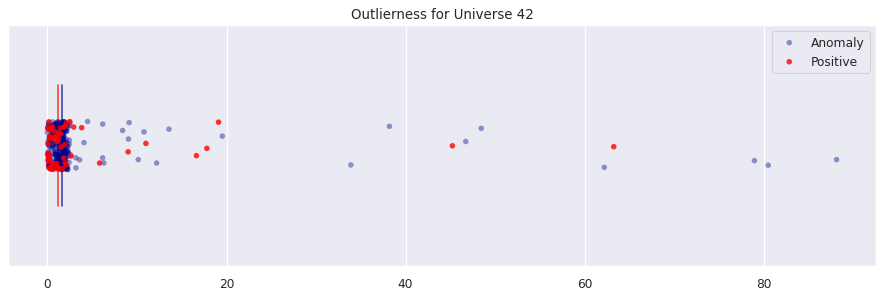

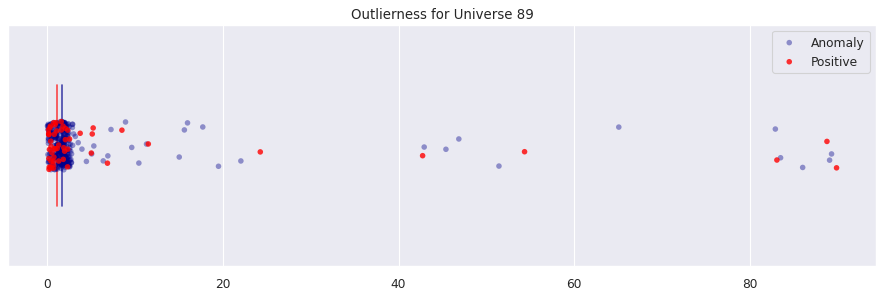

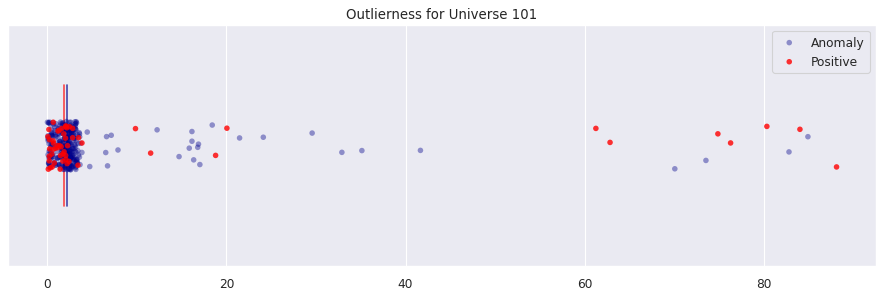

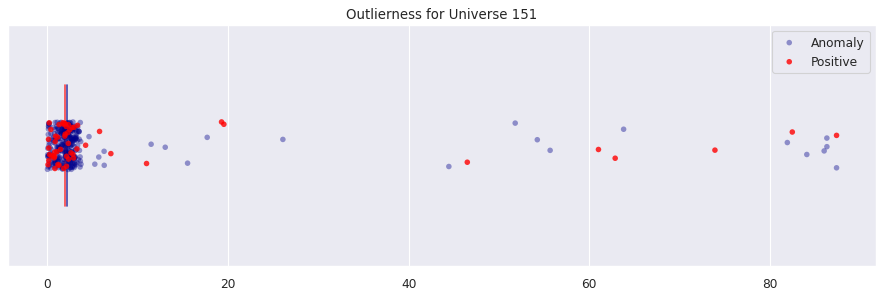

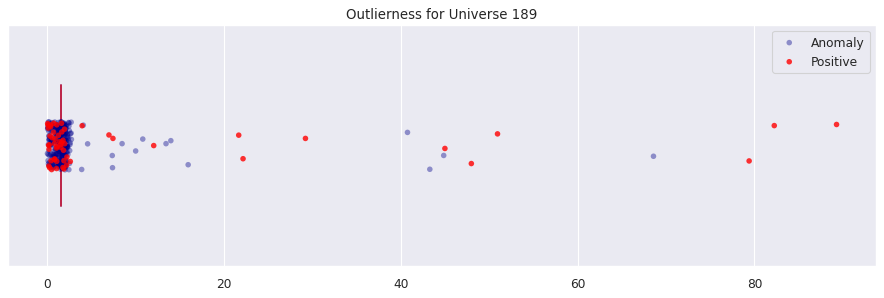

In [23]:
outlierness_supervised(Y_collection, outlierness_dict)

Dropped features: **10** + removed rows

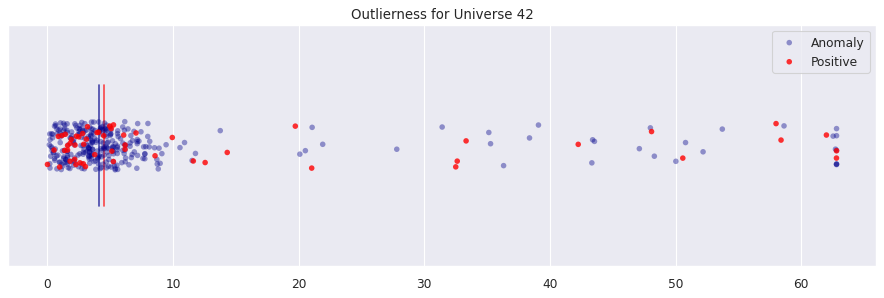

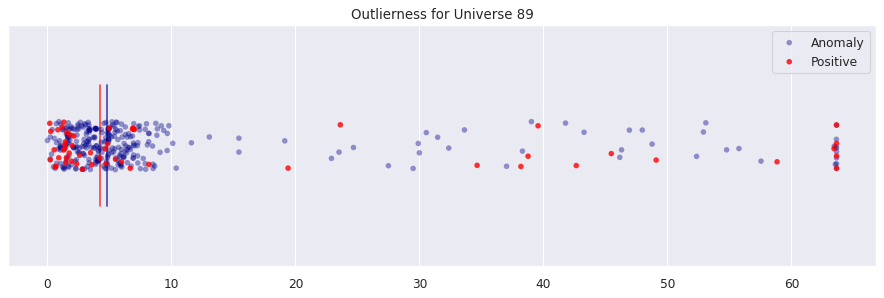

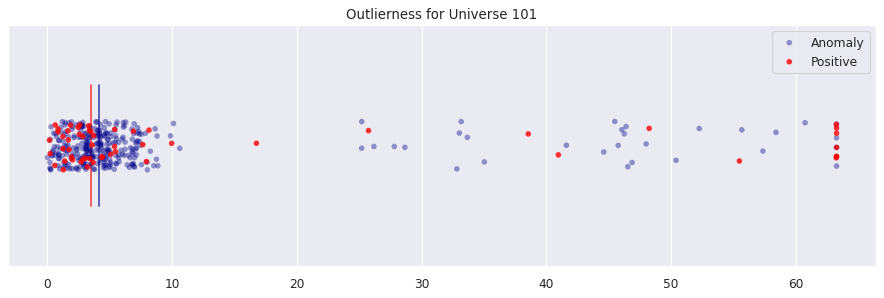

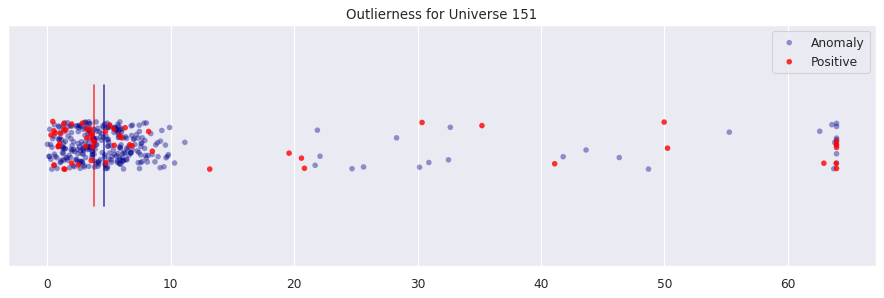

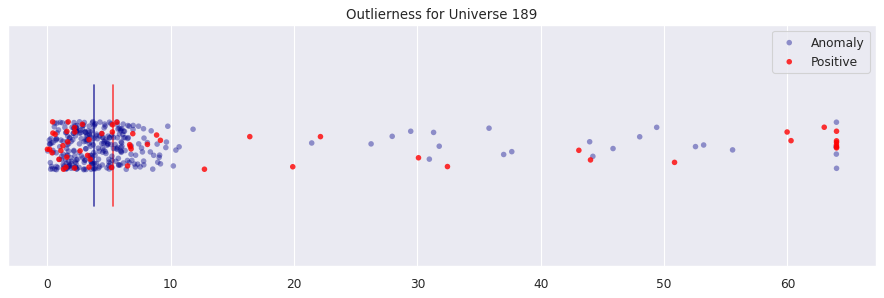

In [30]:
outlierness_supervised(Y_collection, outlierness_dict)

Dropped features: **20**

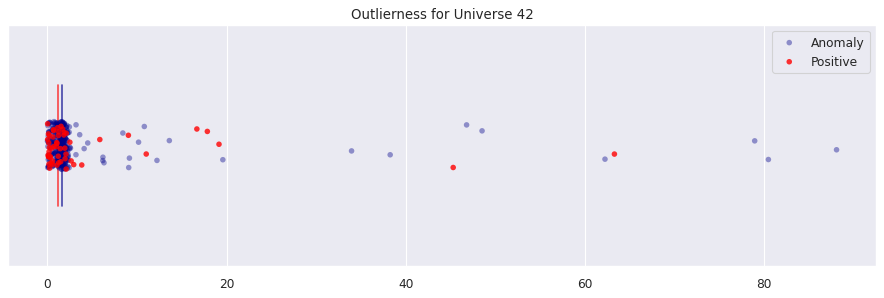

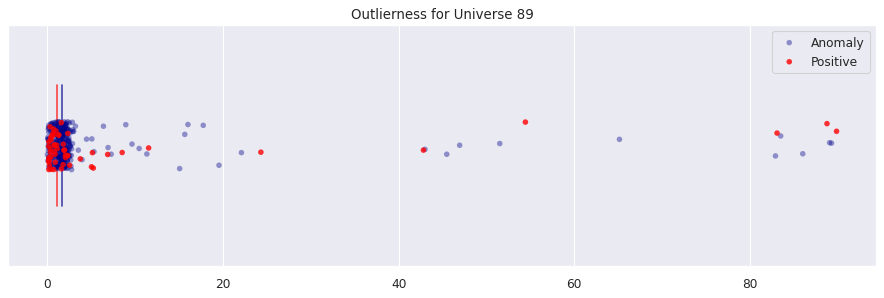

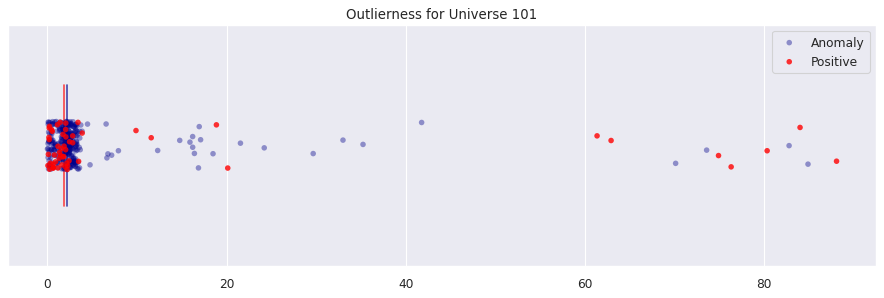

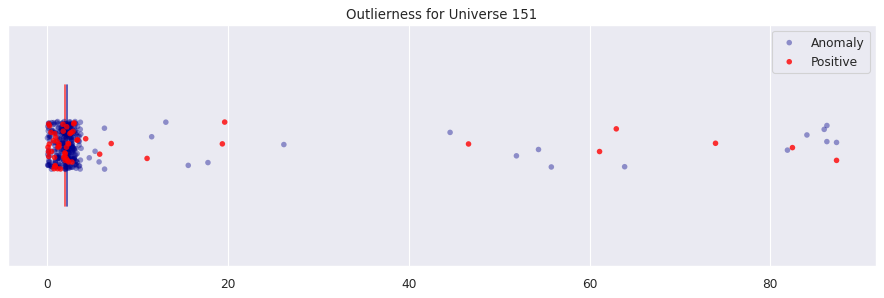

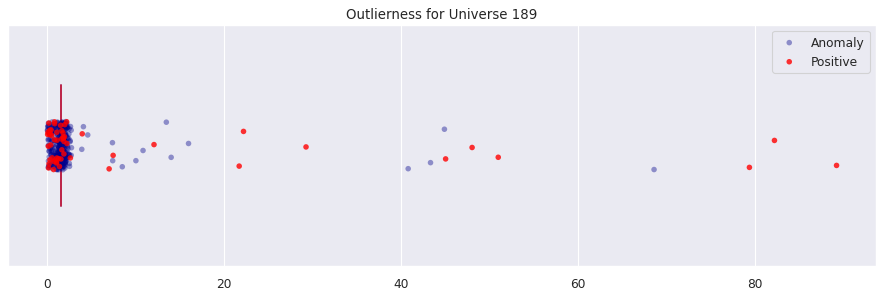

In [36]:
outlierness_supervised(Y_collection, outlierness_dict)

Dropped features: **20** + removed rows

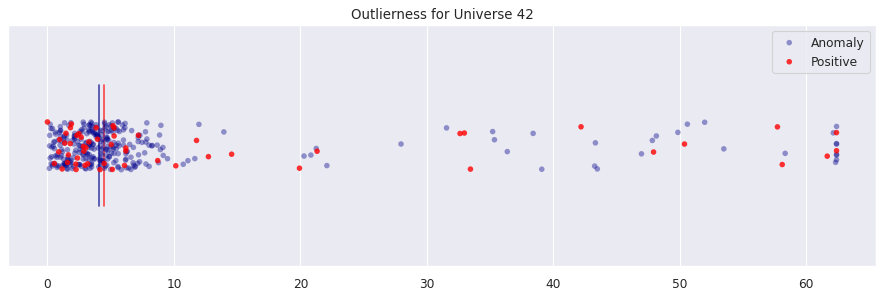

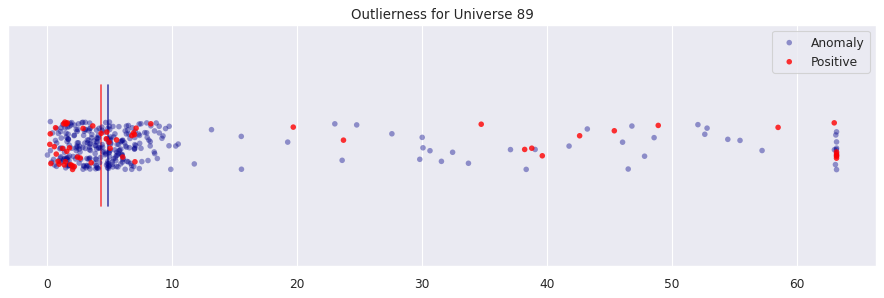

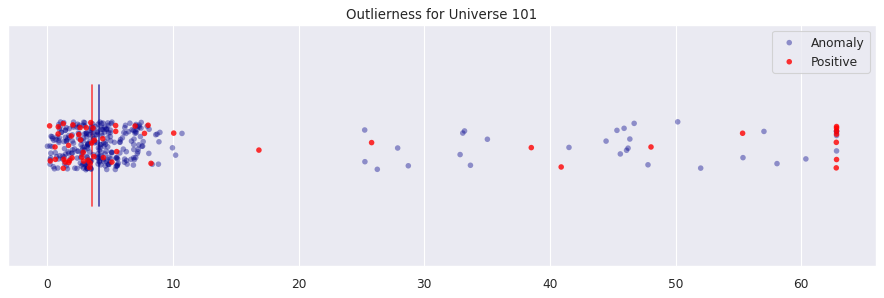

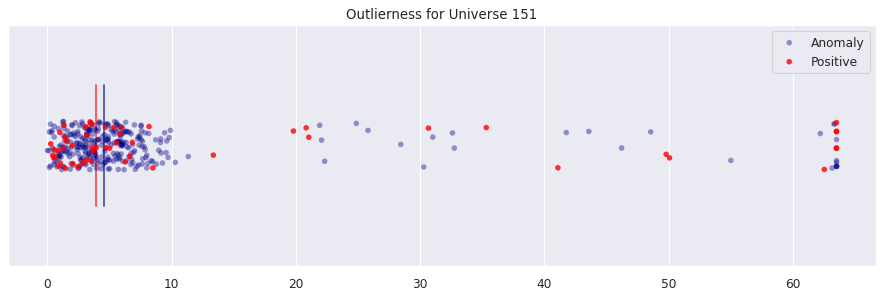

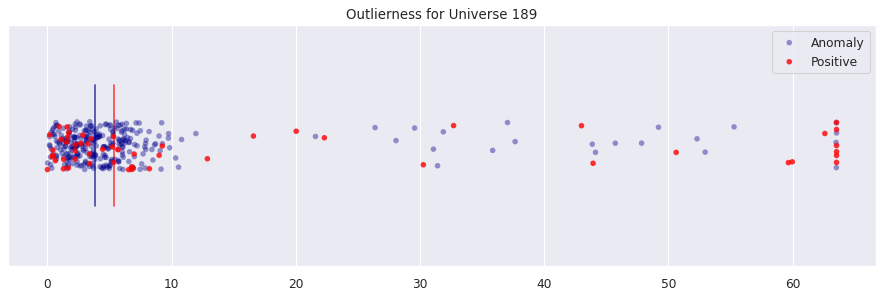

In [43]:
outlierness_supervised(Y_collection, outlierness_dict)

Dropped features: **30**

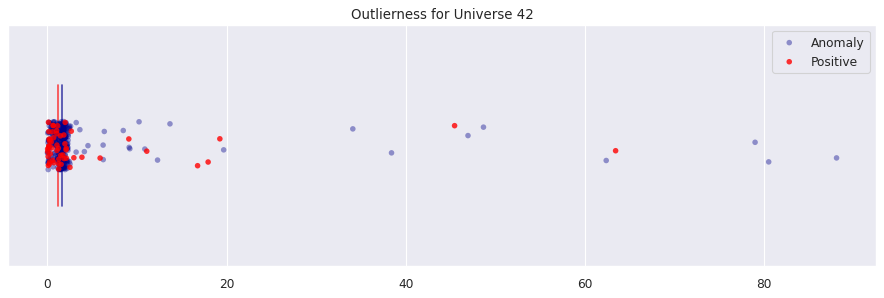

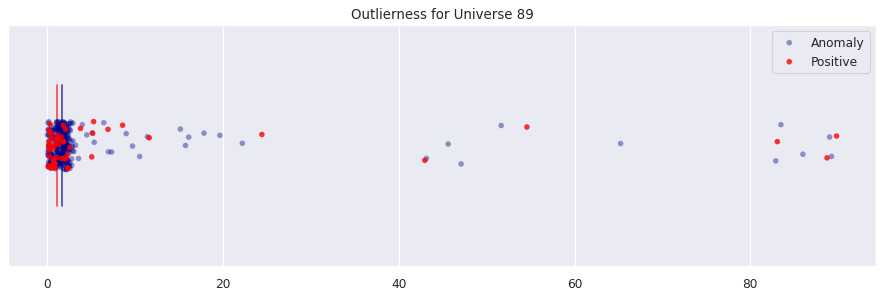

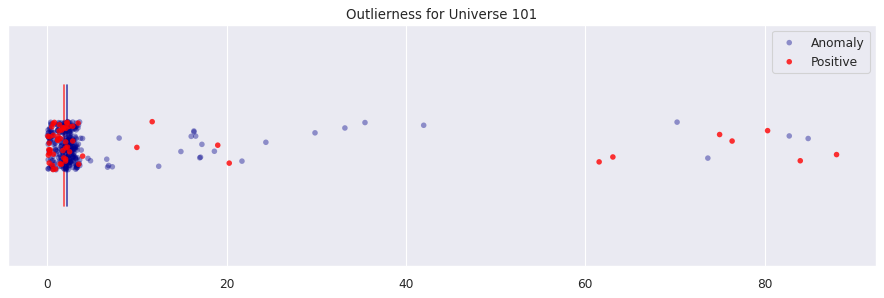

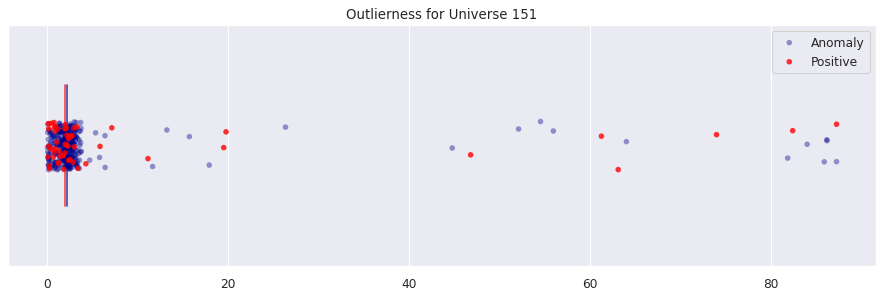

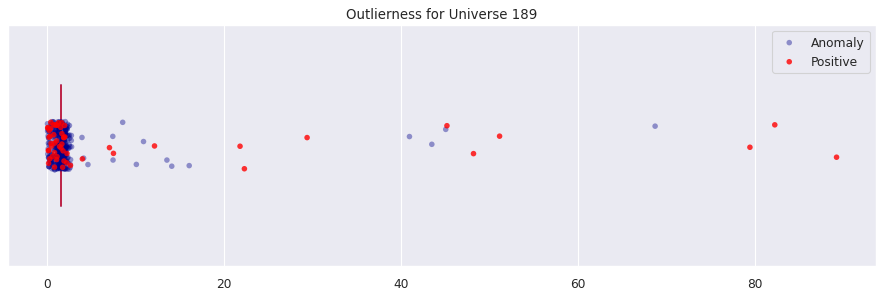

In [49]:
outlierness_supervised(Y_collection, outlierness_dict)

Dropped features: **30** + removed rows

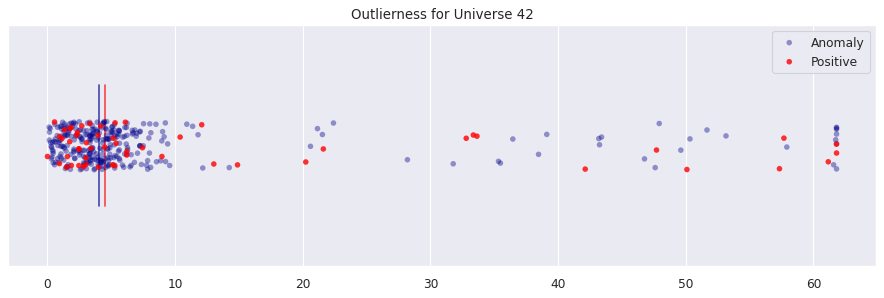

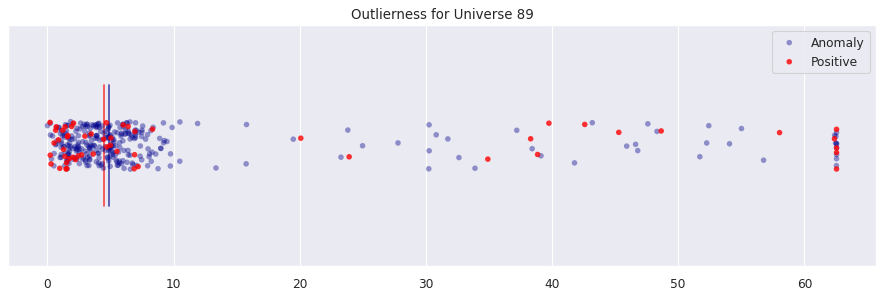

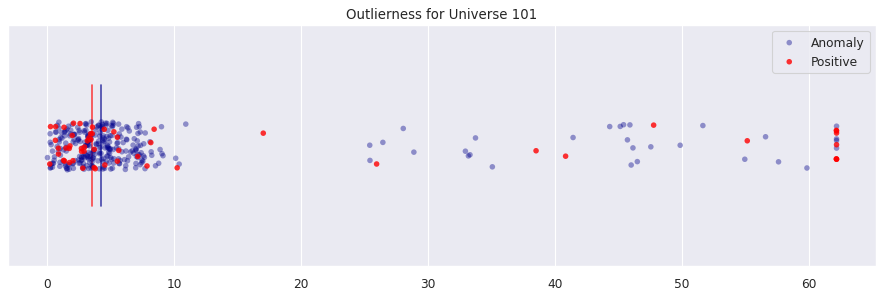

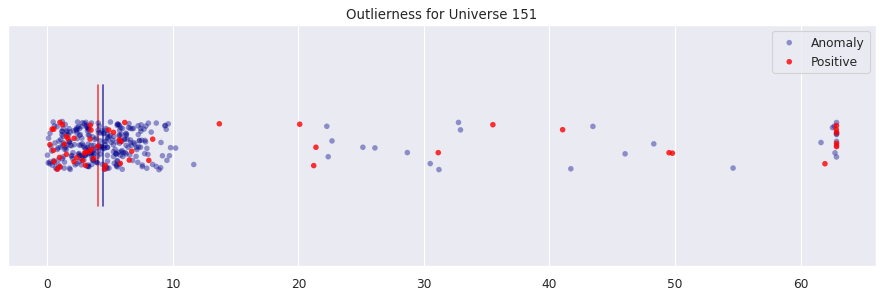

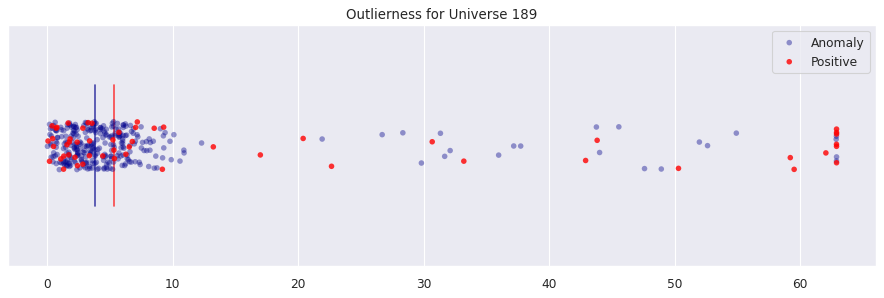

In [56]:
outlierness_supervised(Y_collection, outlierness_dict)

#### Removing features with MAD RANKING

Dropped features: **10**

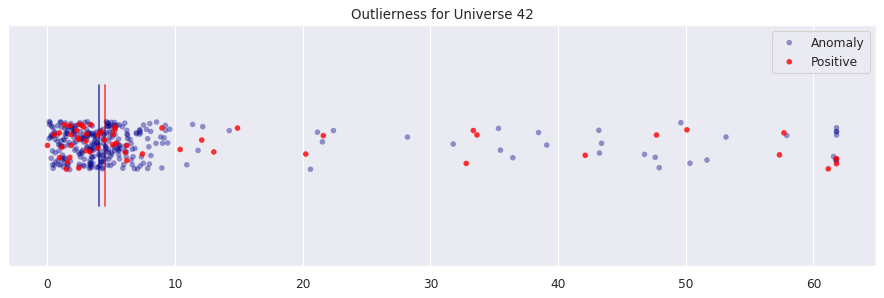

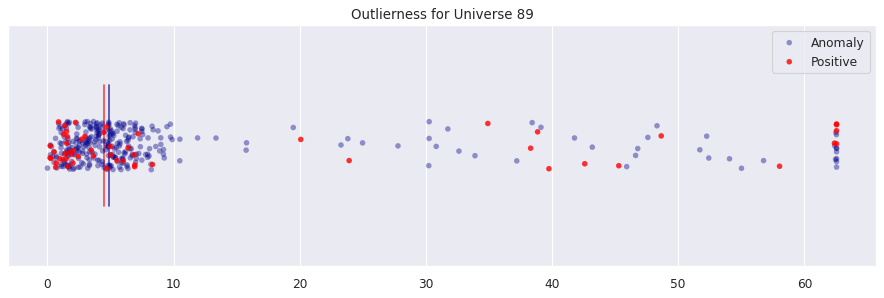

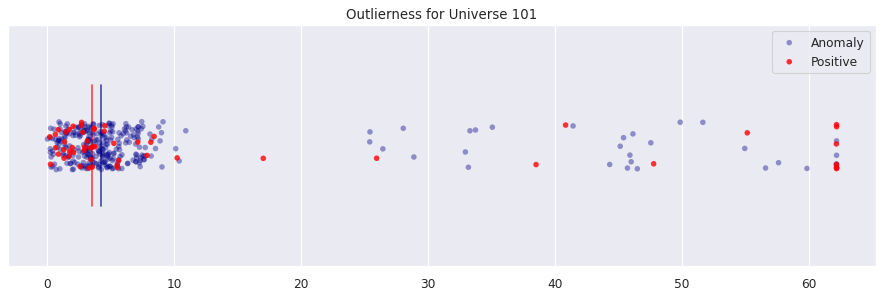

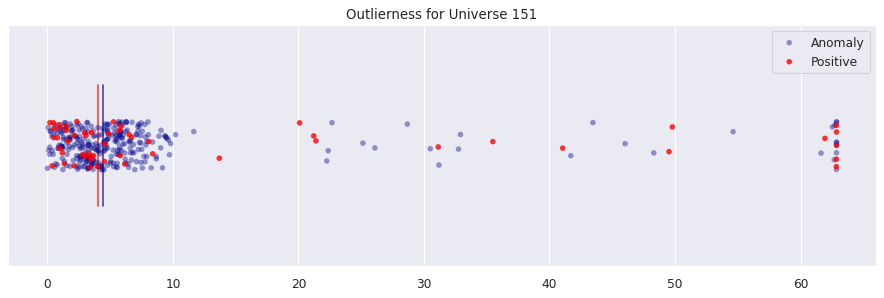

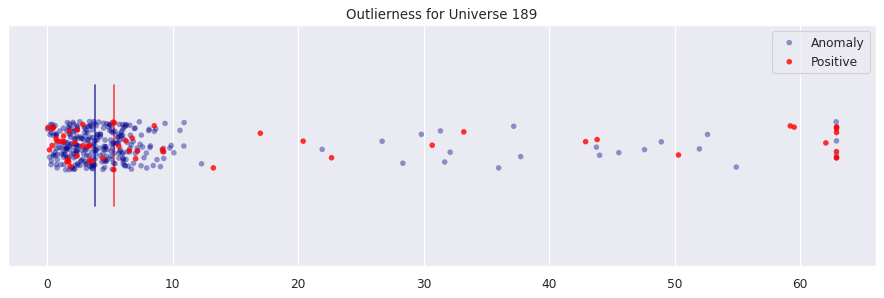

In [60]:
outlierness_supervised(Y_collection, outlierness_dict)

Dropped features: **10** + removed rows

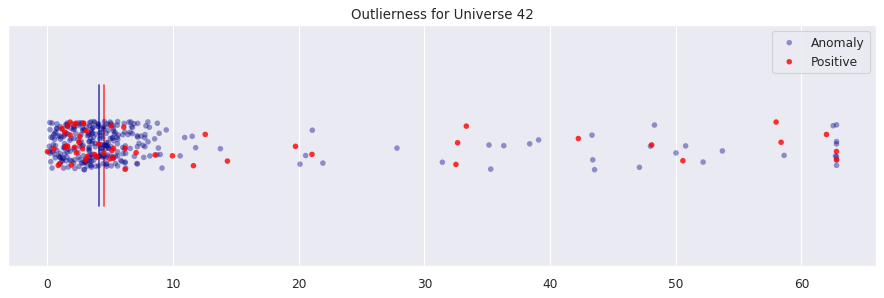

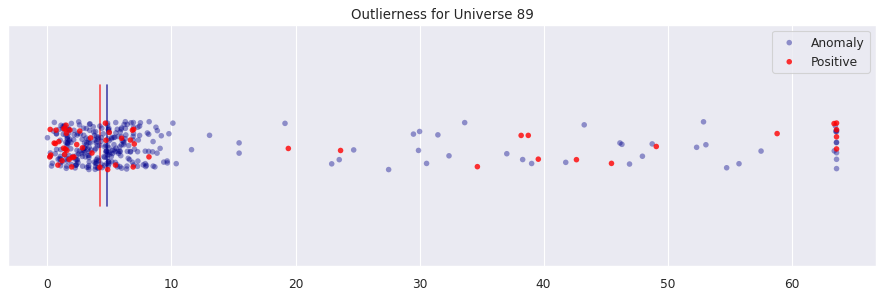

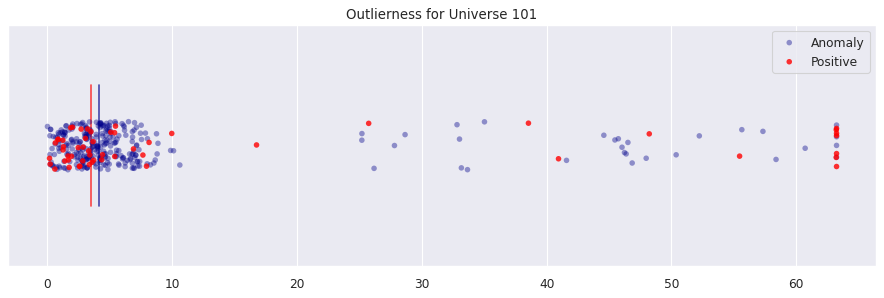

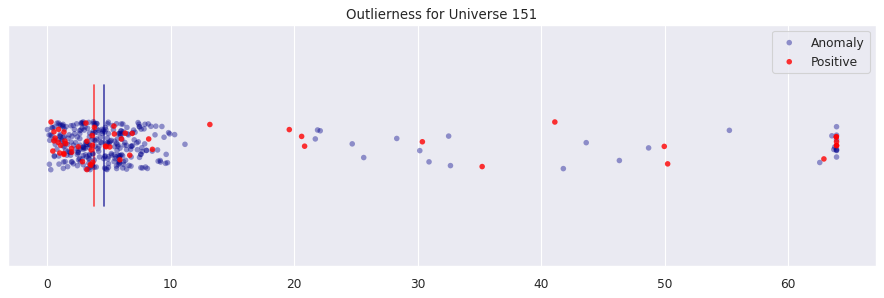

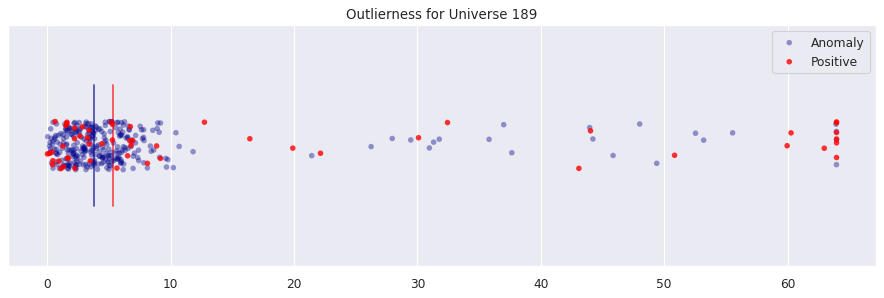

In [67]:
outlierness_supervised(Y_collection, outlierness_dict)

Dropped features: **20**

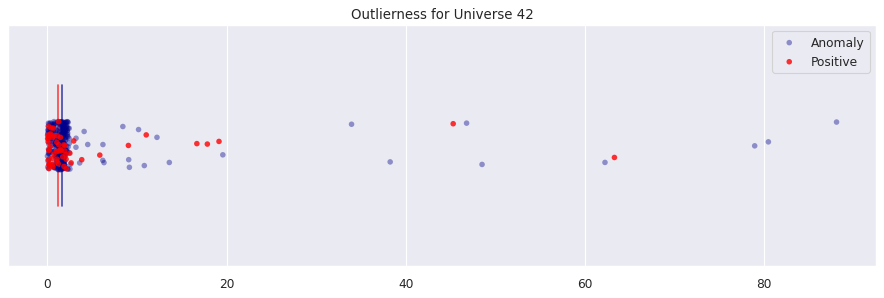

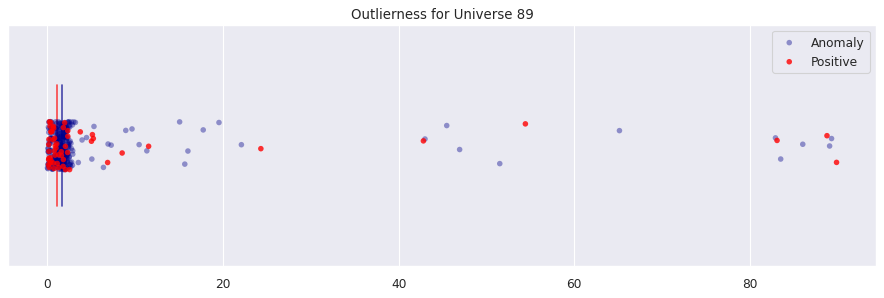

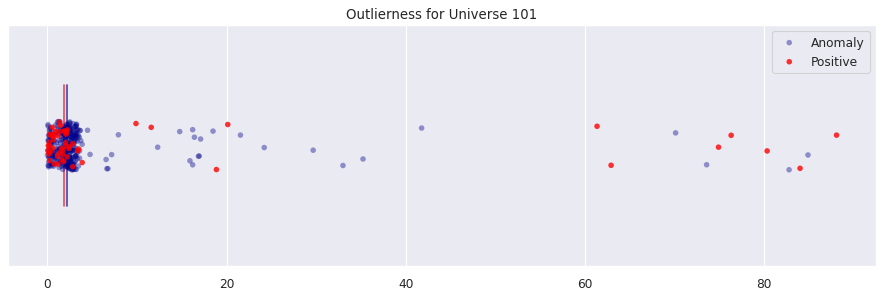

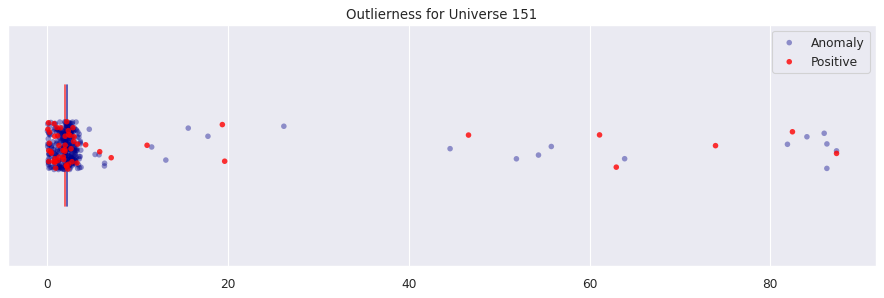

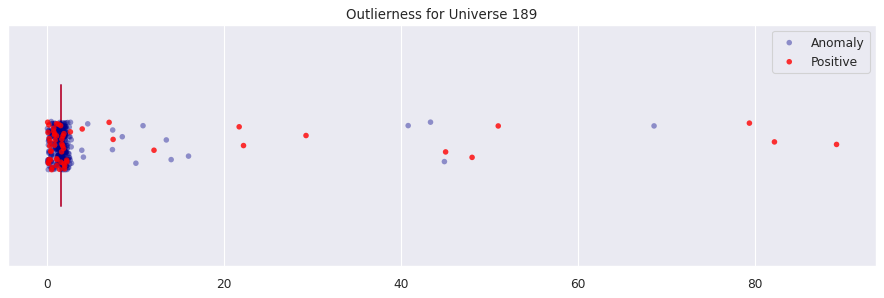

In [74]:
outlierness_supervised(Y_collection, outlierness_dict)

Dropped features: **20** + removed rows

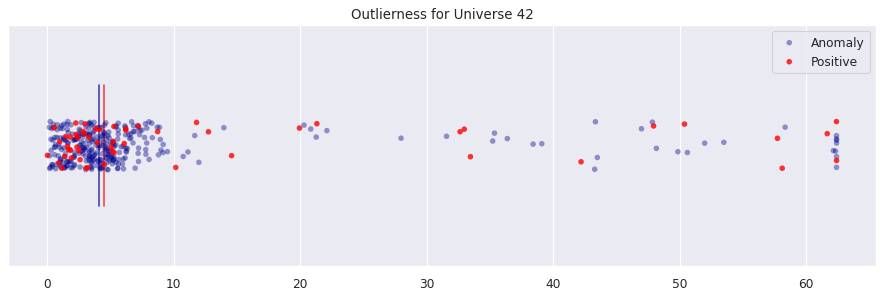

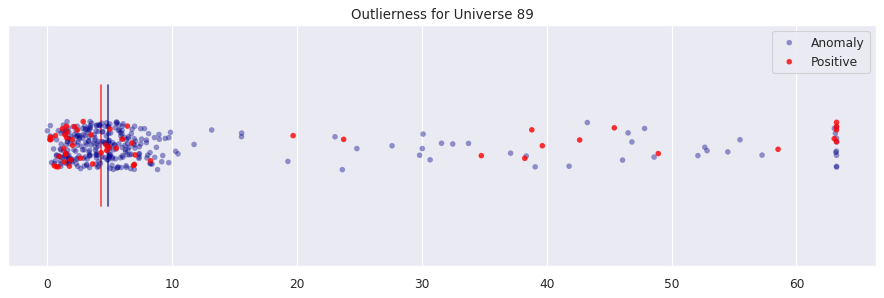

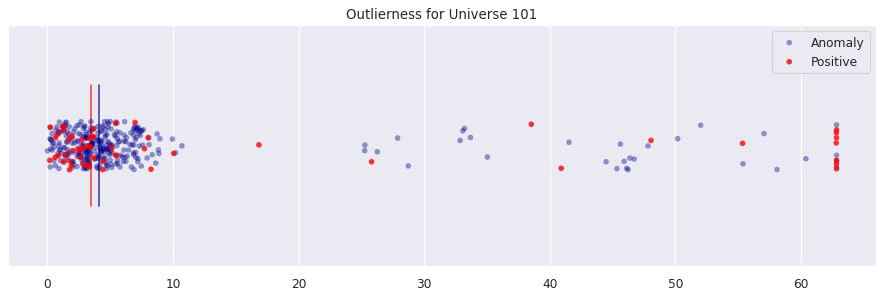

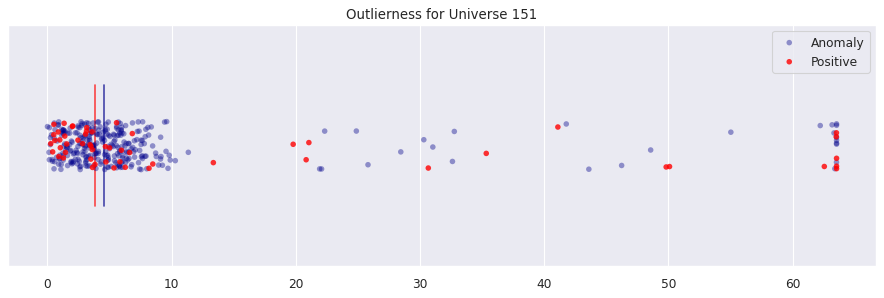

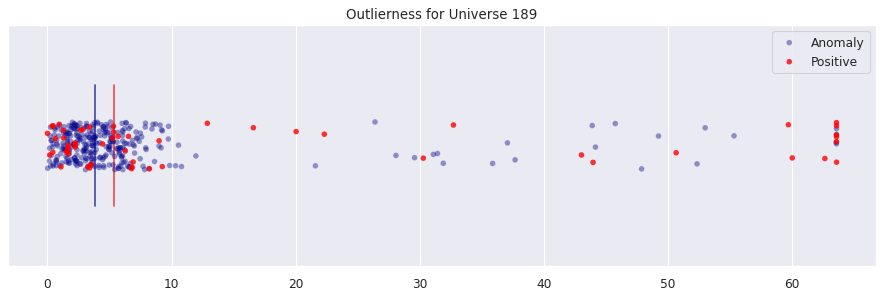

In [81]:
outlierness_supervised(Y_collection, outlierness_dict)

Dropped features: **30**

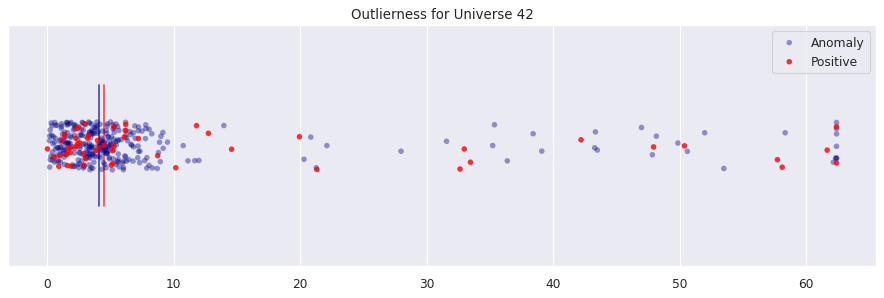

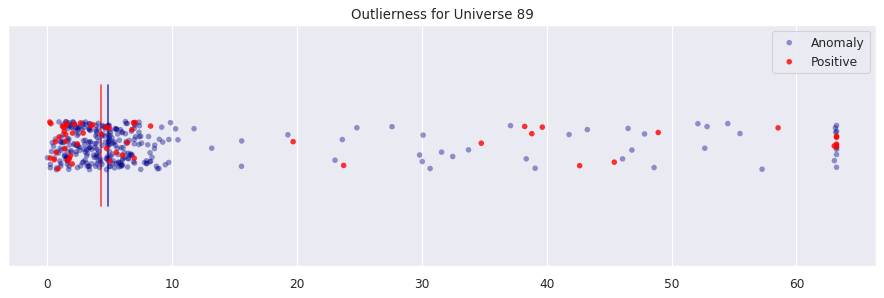

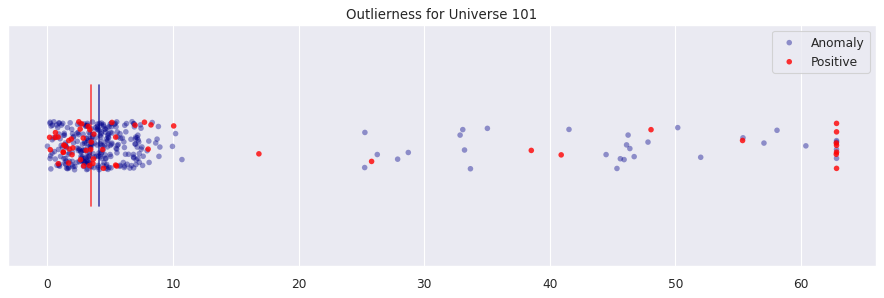

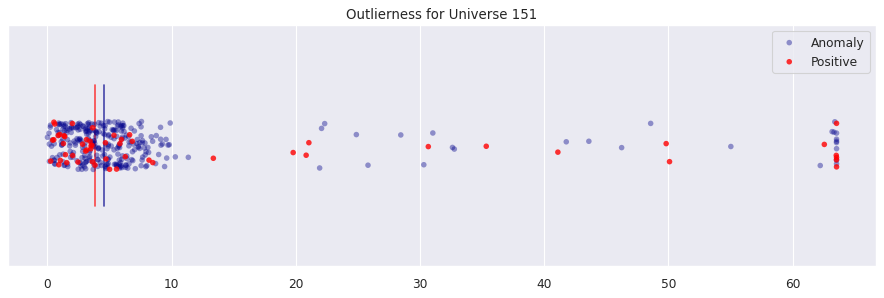

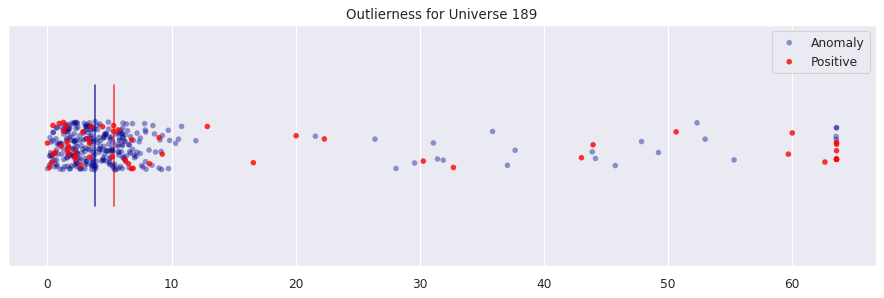

In [87]:
outlierness_supervised(Y_collection, outlierness_dict)

Dropped features: **30** + removed rows

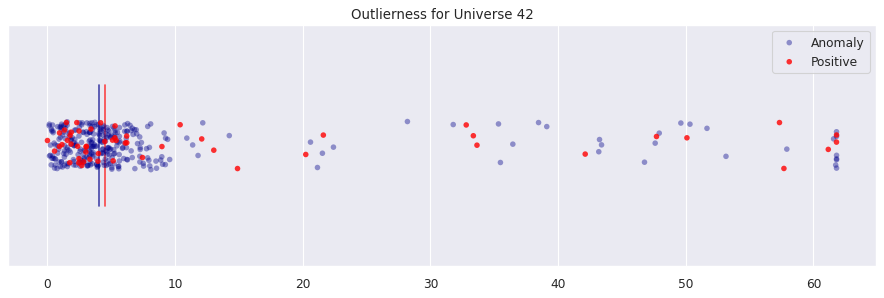

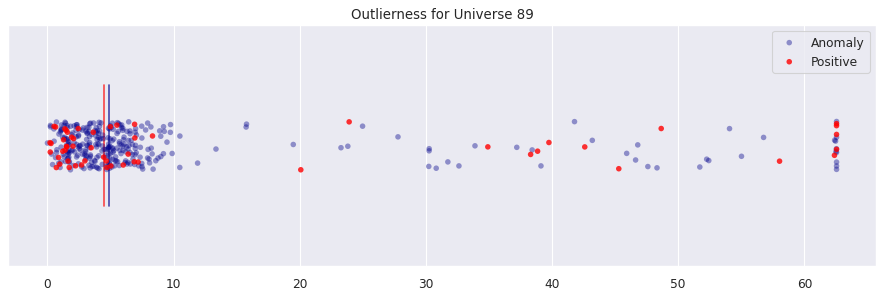

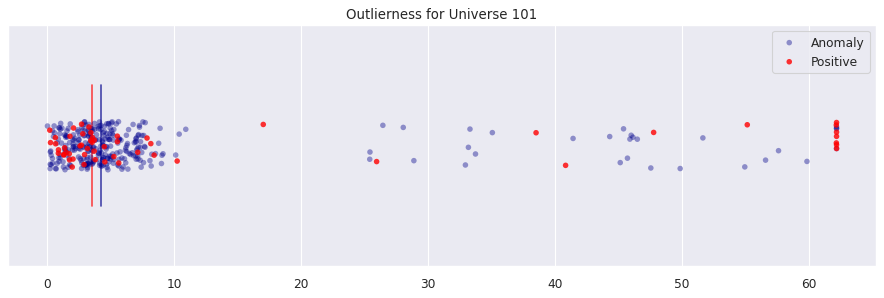

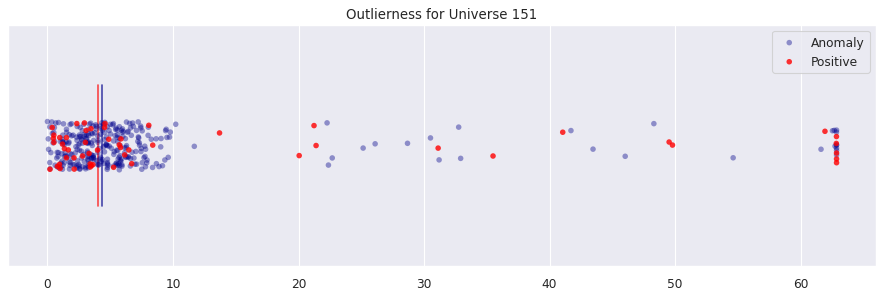

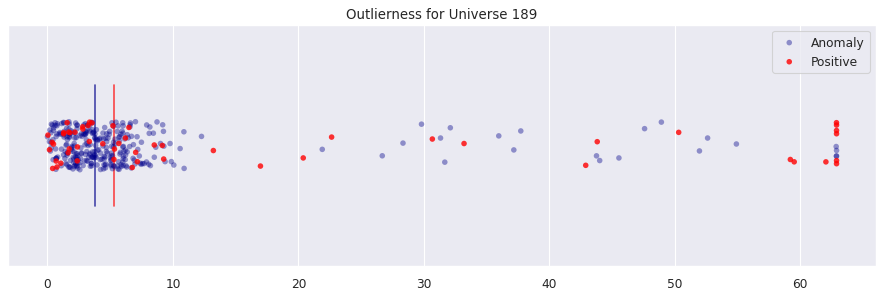

In [94]:
outlierness_supervised(Y_collection, outlierness_dict)

#### Removing features with VARIANCE RATIO RANKING

Dropped features: **10**

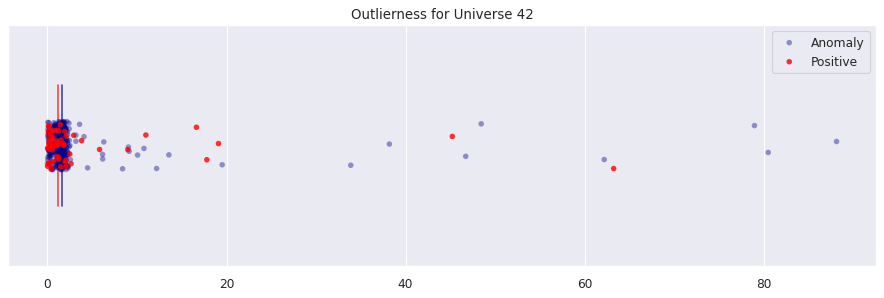

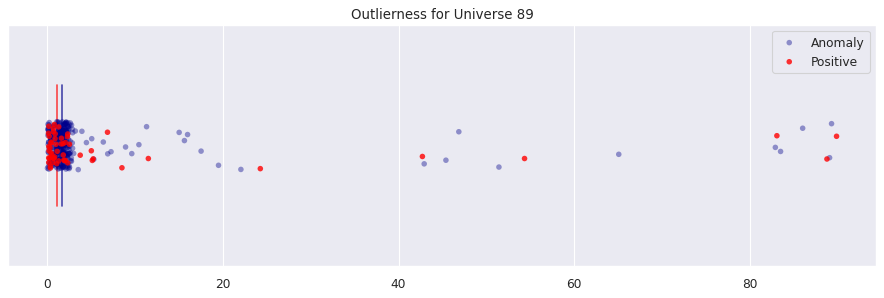

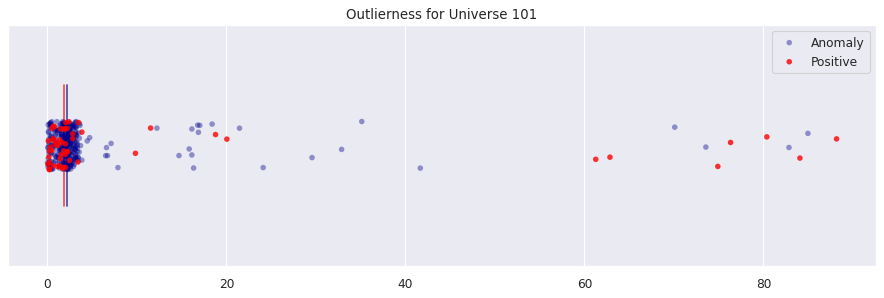

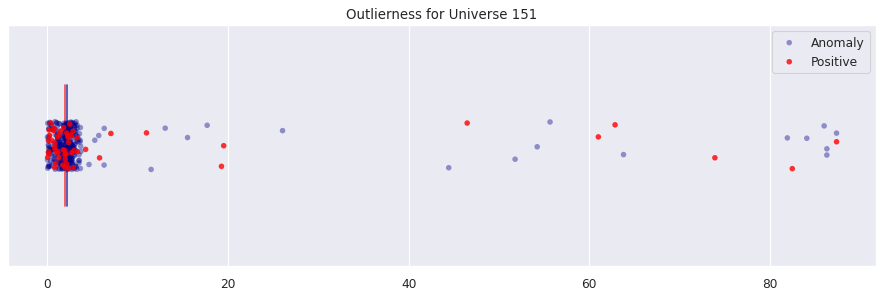

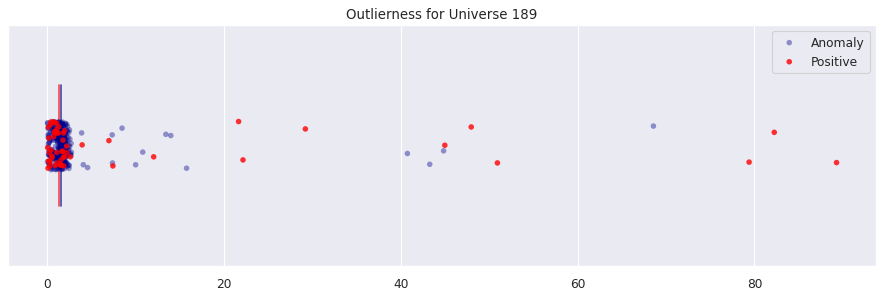

In [100]:
outlierness_supervised(Y_collection, outlierness_dict)

Dropped features: **10** + removed rows

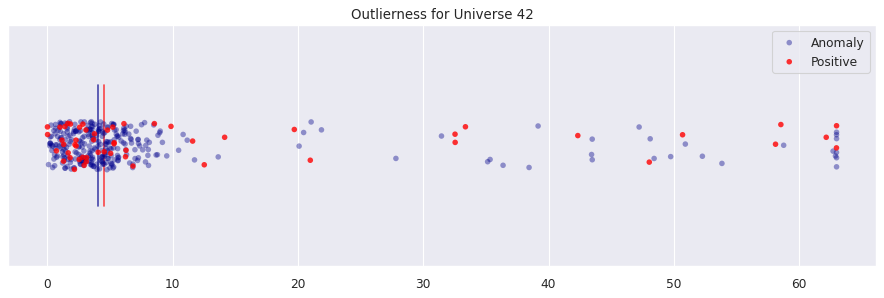

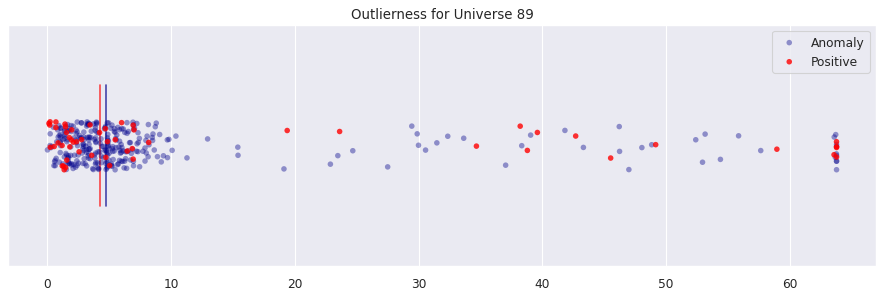

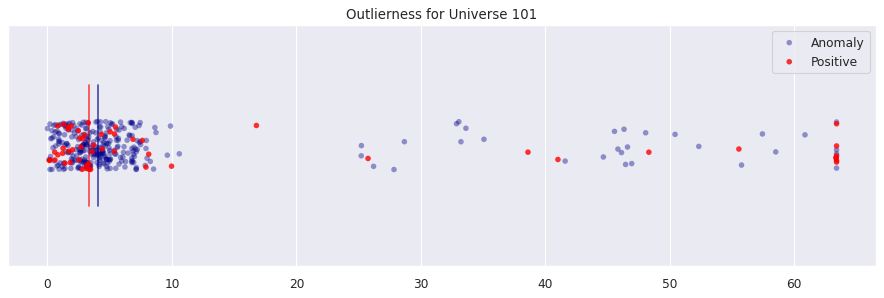

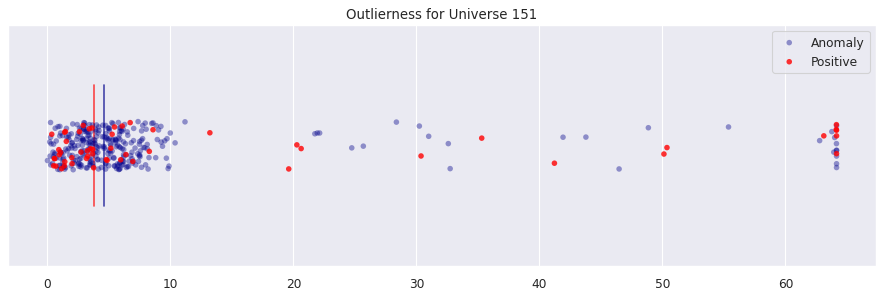

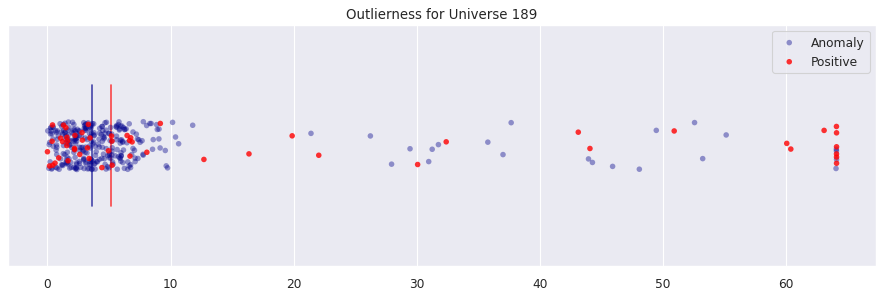

In [107]:
outlierness_supervised(Y_collection, outlierness_dict)

Dropped features: **20**

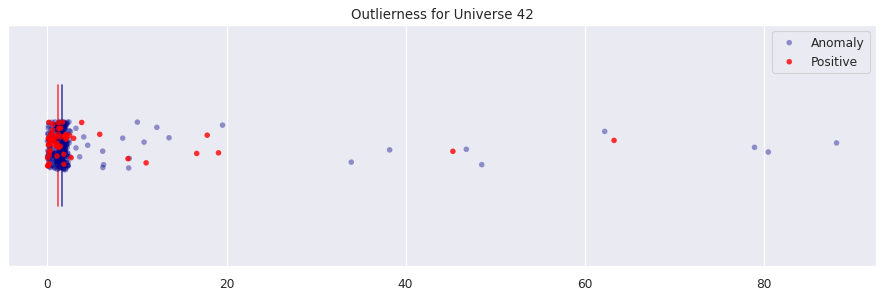

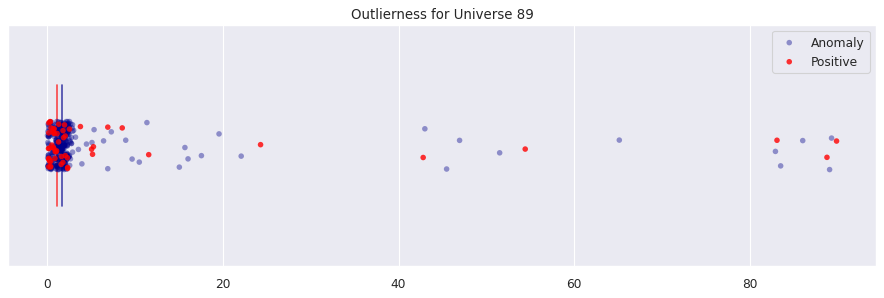

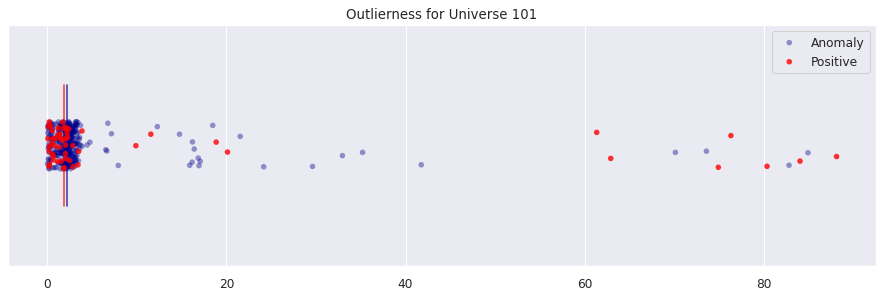

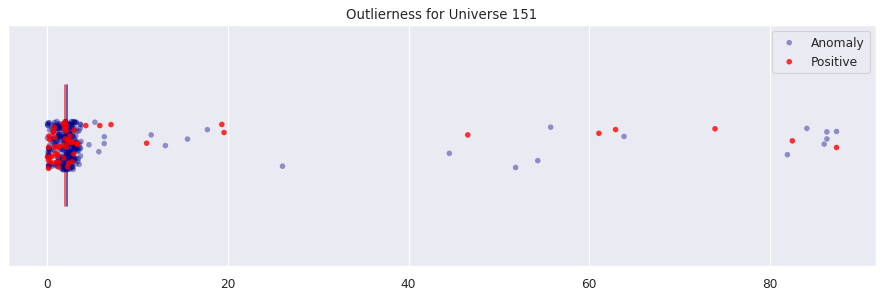

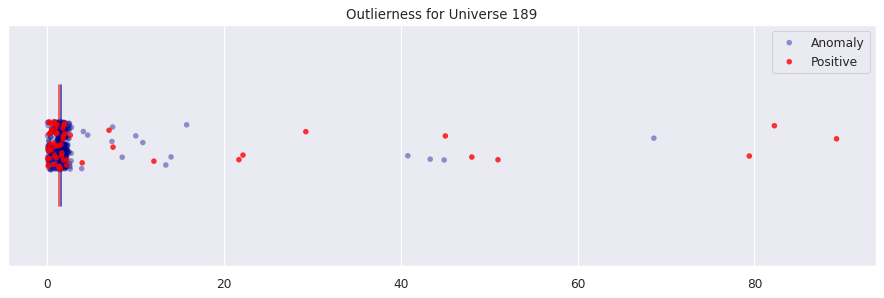

In [113]:
outlierness_supervised(Y_collection, outlierness_dict)

Dropped features: **20** + removed rows

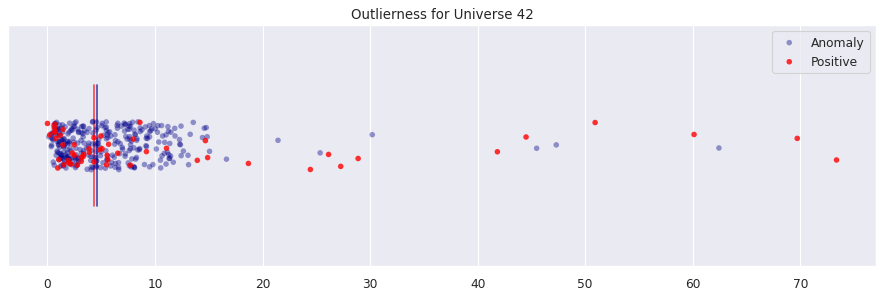

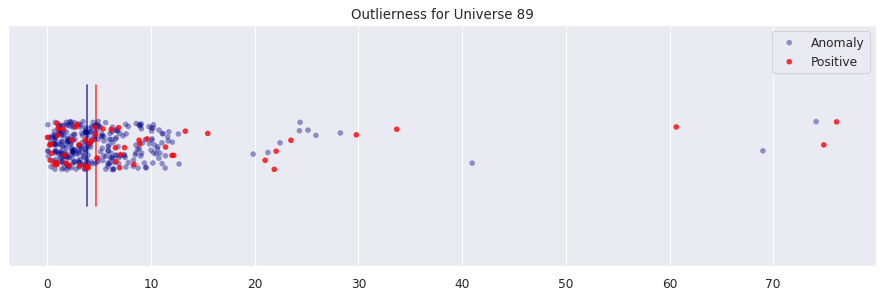

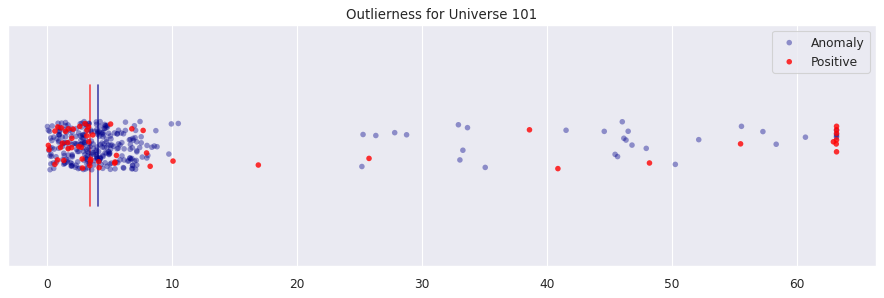

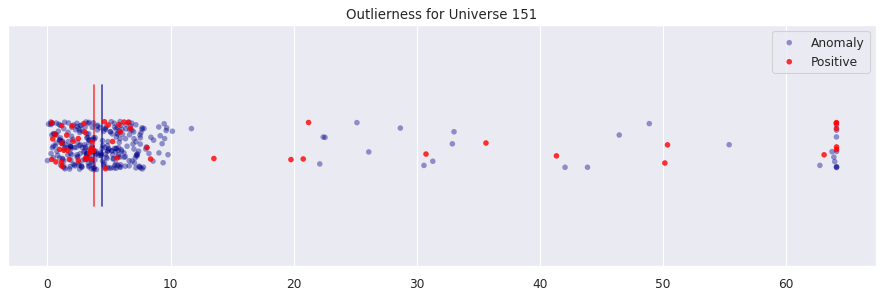

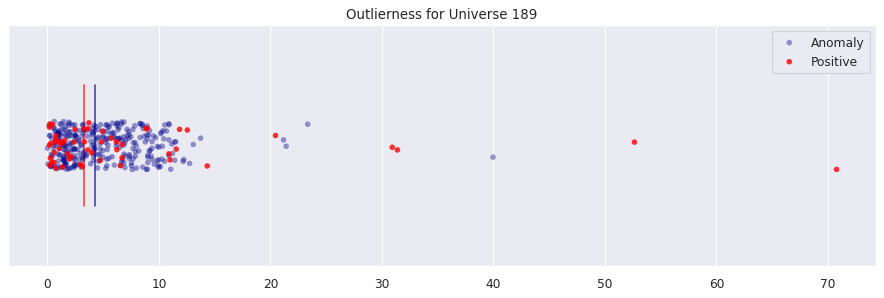

In [120]:
outlierness_supervised(Y_collection, outlierness_dict)

Dropped features: **30**

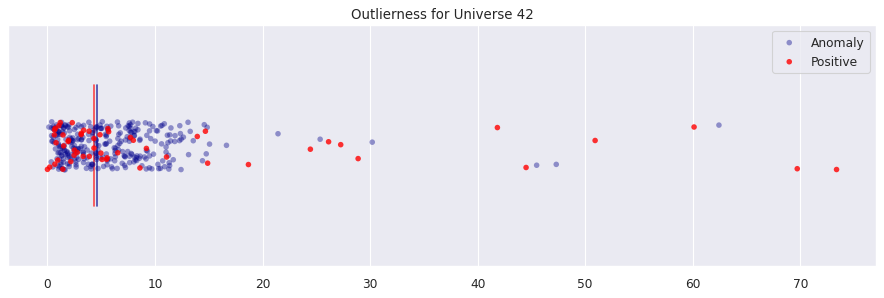

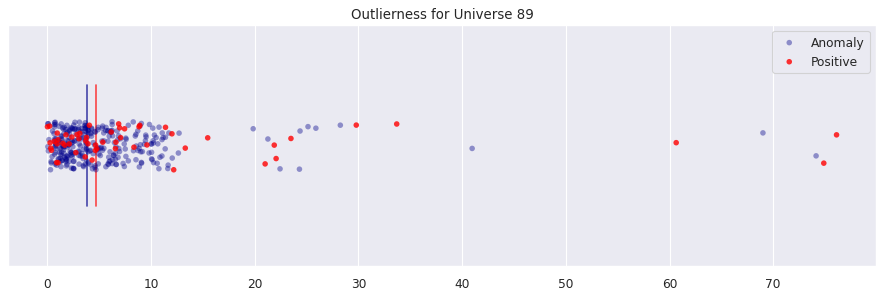

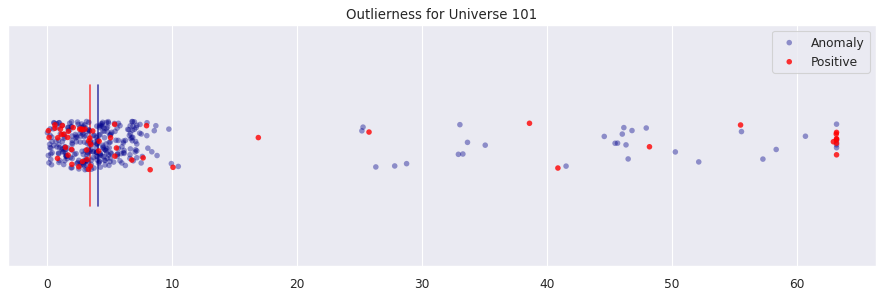

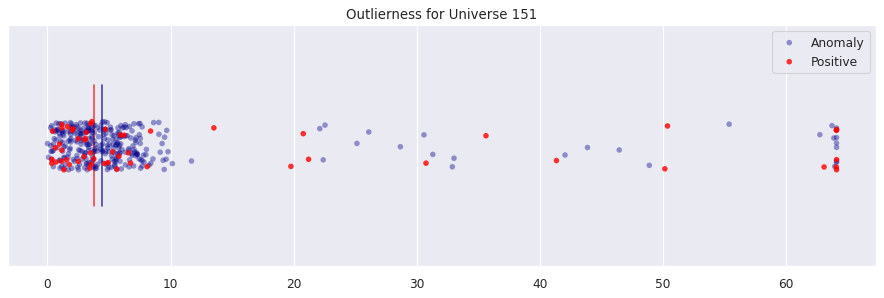

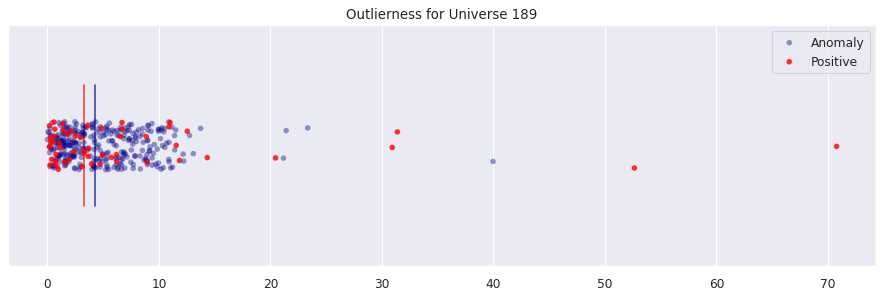

In [124]:
outlierness_supervised(Y_collection, outlierness_dict)

Dropped features: **30** + removed rows

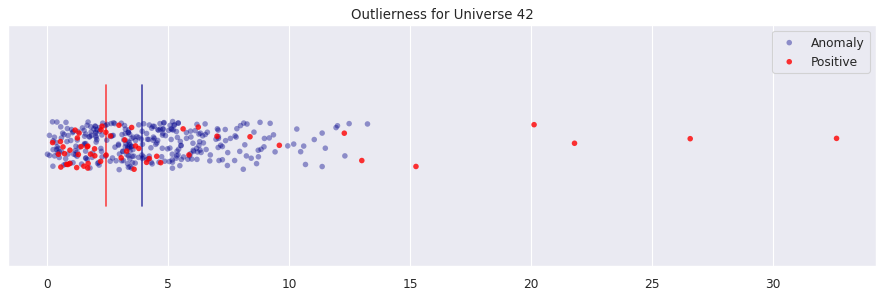

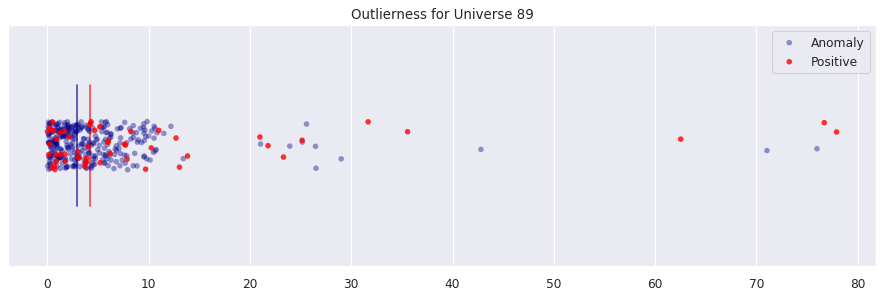

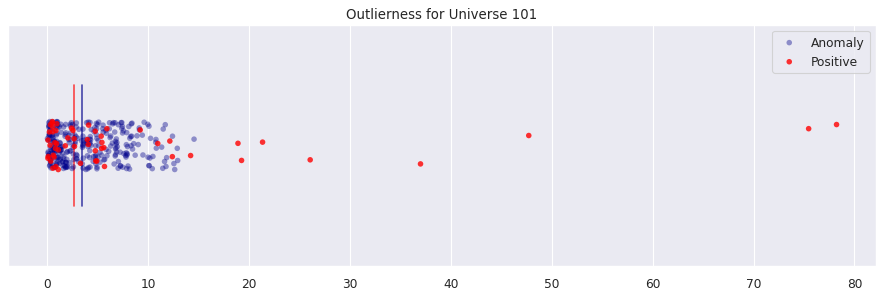

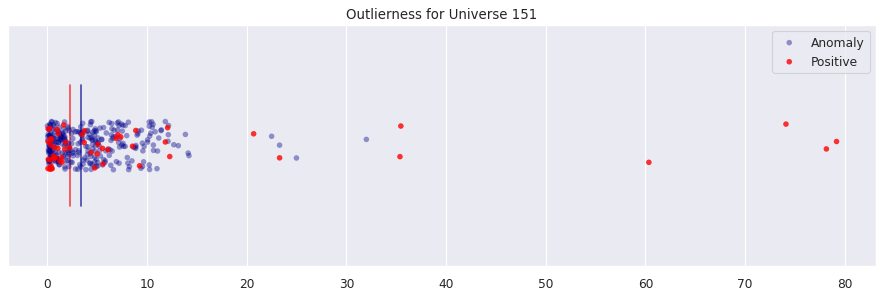

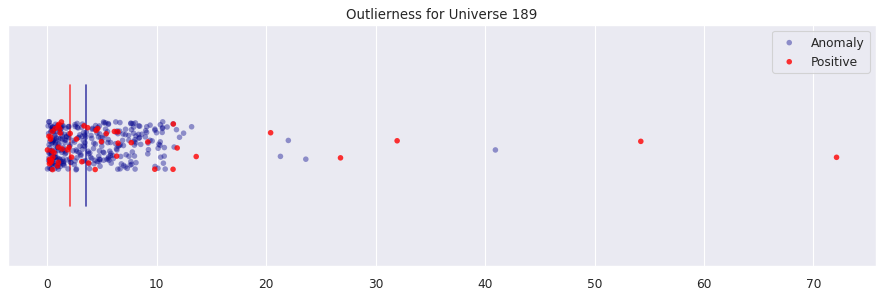

In [131]:
outlierness_supervised(Y_collection, outlierness_dict)

#### Removing features with MAD RANKING

Dropped features: **10**

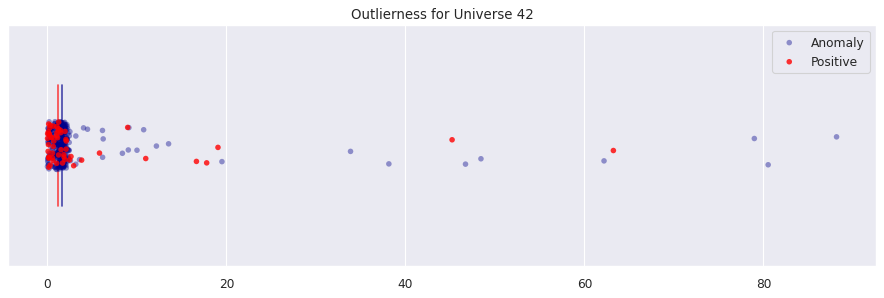

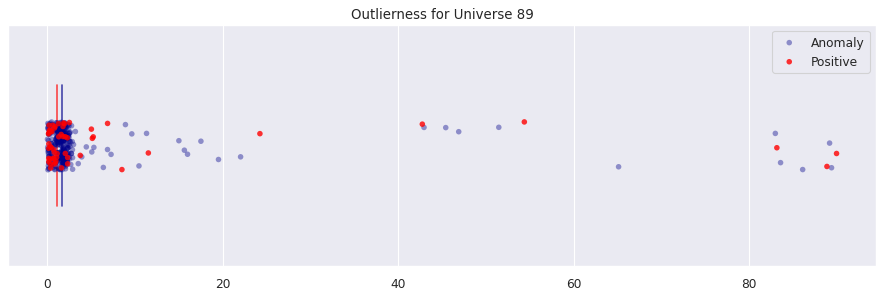

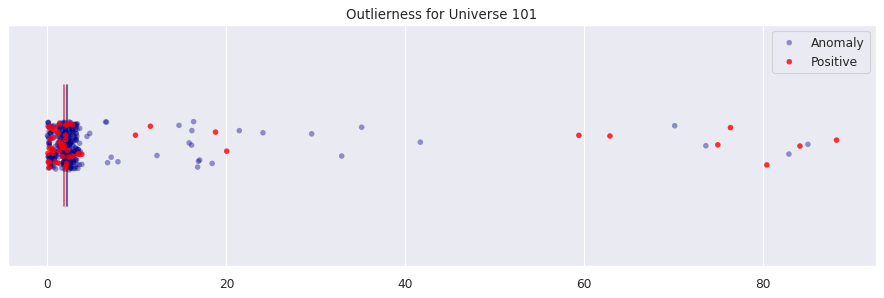

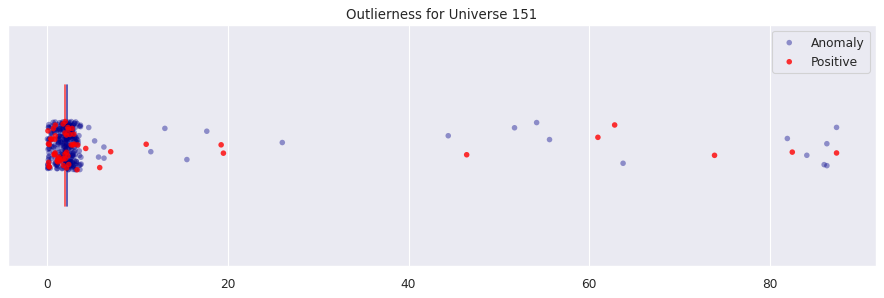

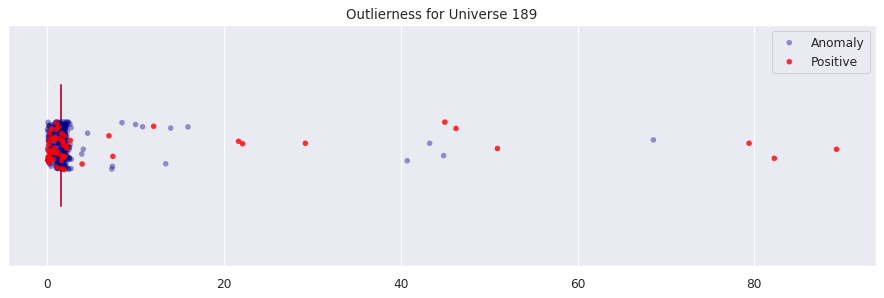

In [139]:
outlierness_supervised(Y_collection, outlierness_dict)

Dropped features: **10** + removed rows

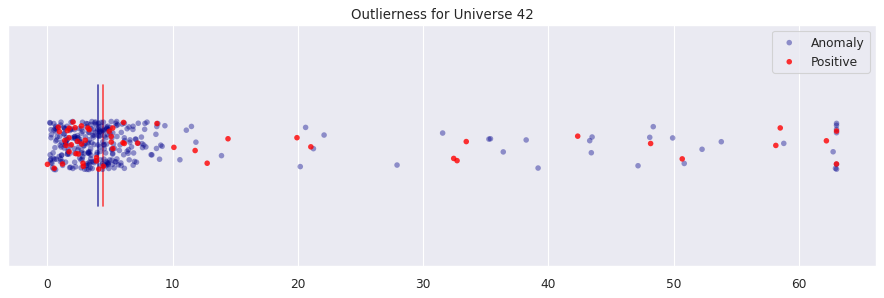

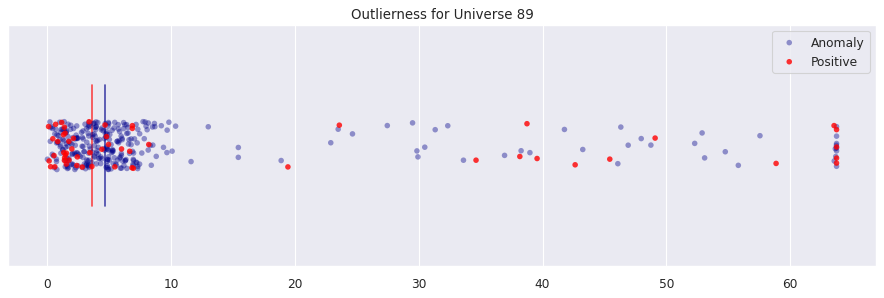

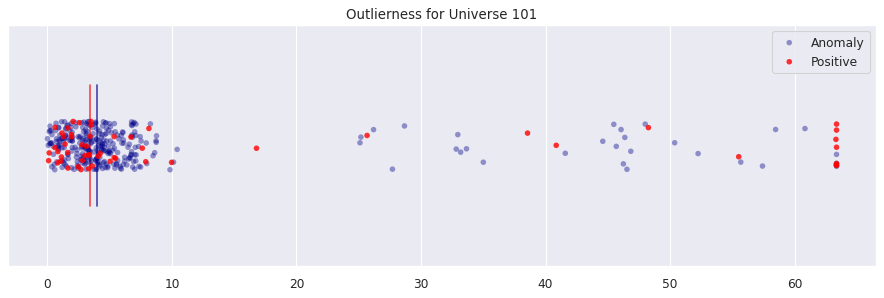

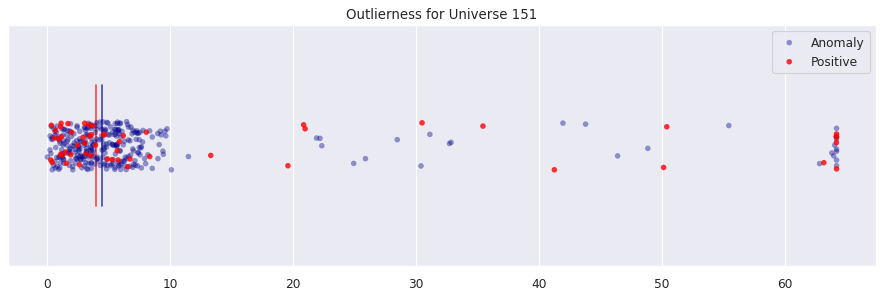

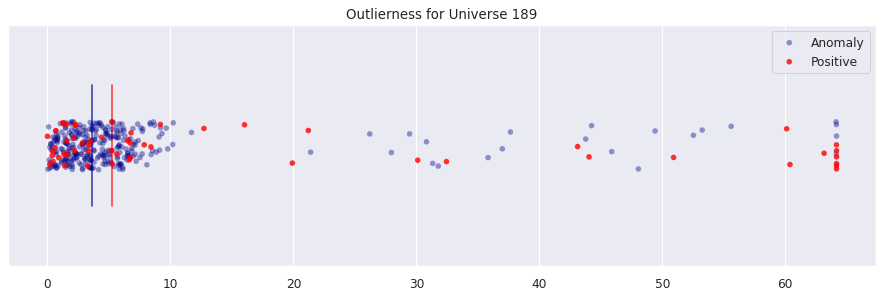

In [146]:
outlierness_supervised(Y_collection, outlierness_dict)

Dropped features: **20**

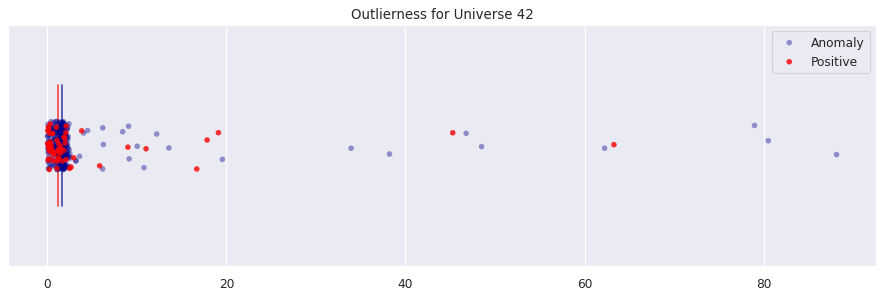

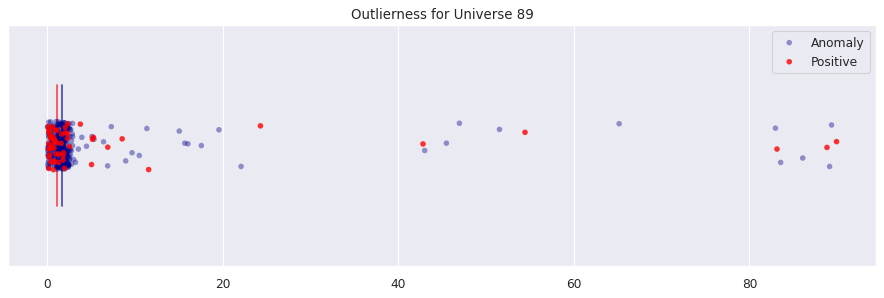

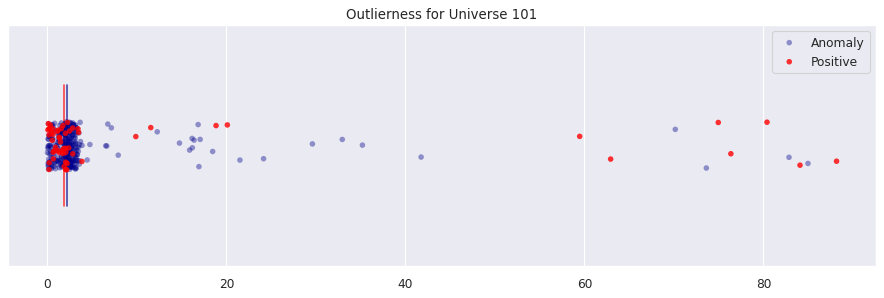

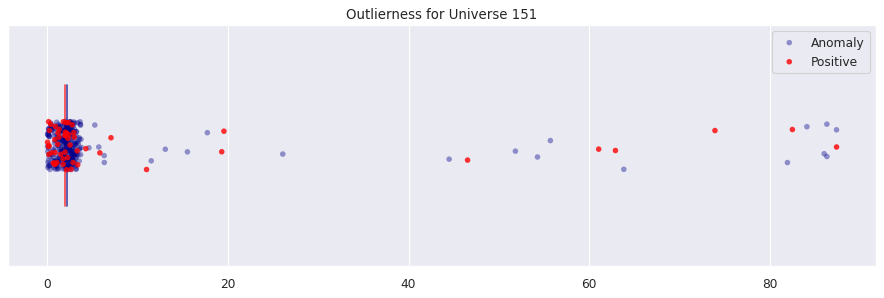

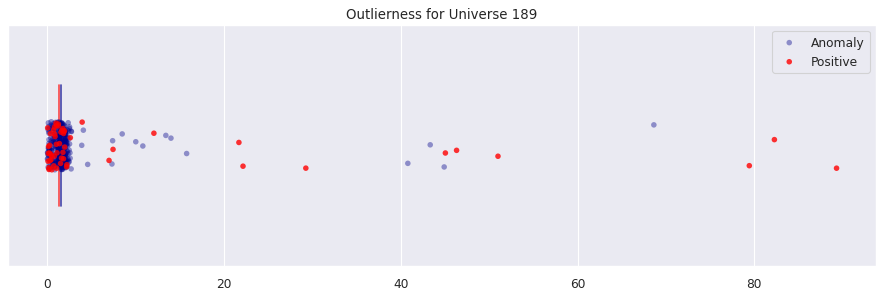

In [152]:
outlierness_supervised(Y_collection, outlierness_dict)

Dropped features: **20** + removed rows

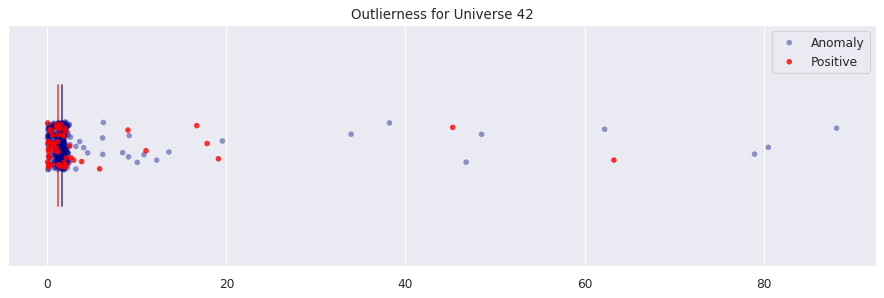

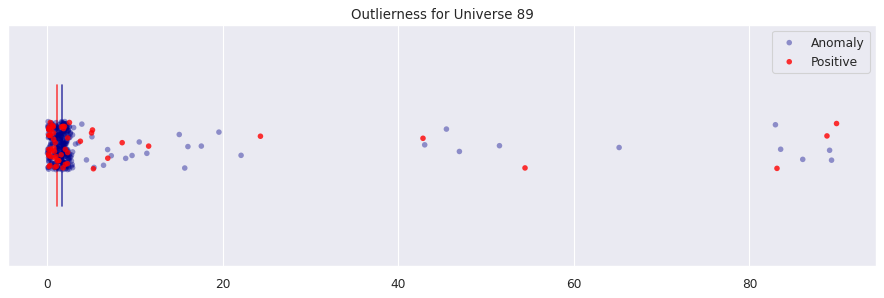

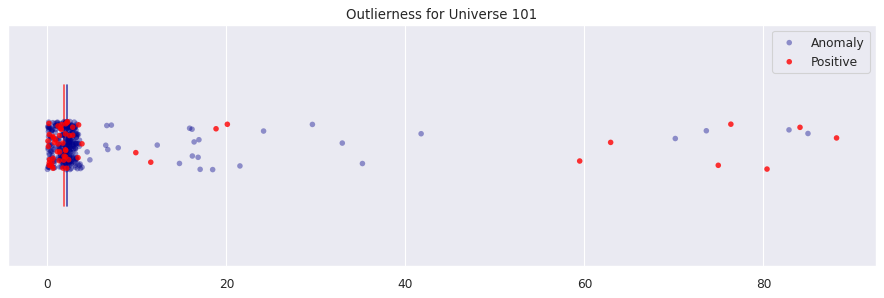

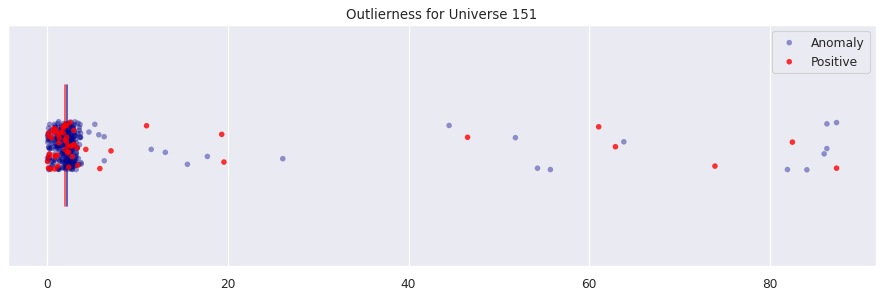

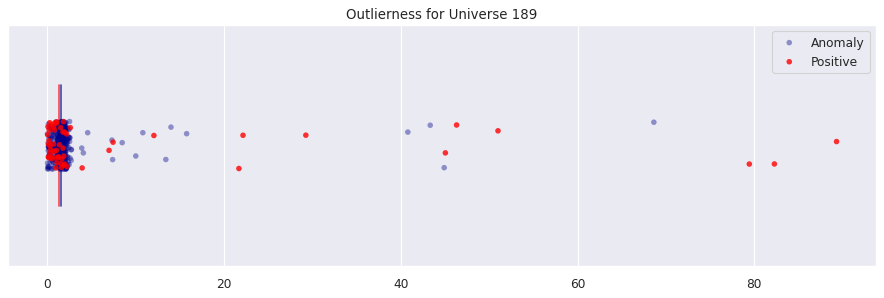

In [157]:
outlierness_supervised(Y_collection, outlierness_dict)

Dropped features: **30**

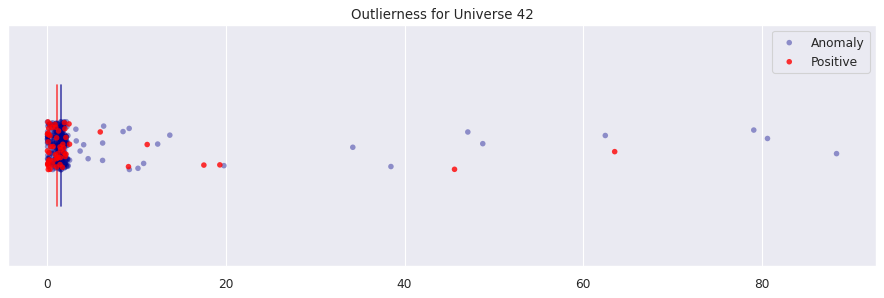

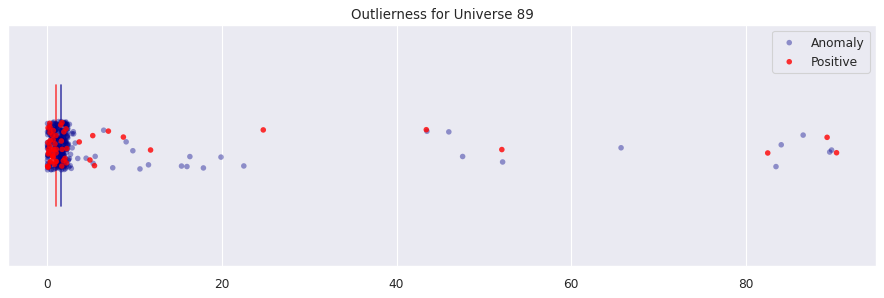

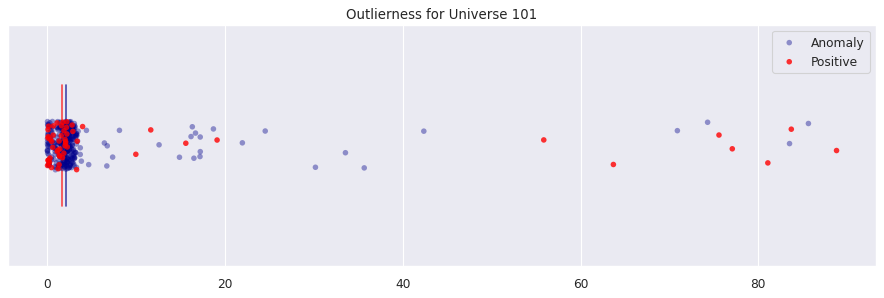

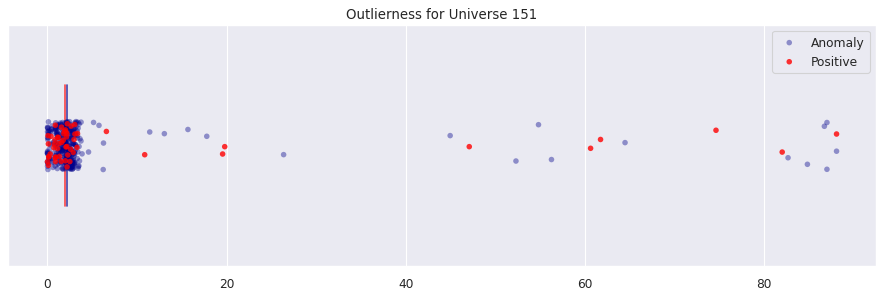

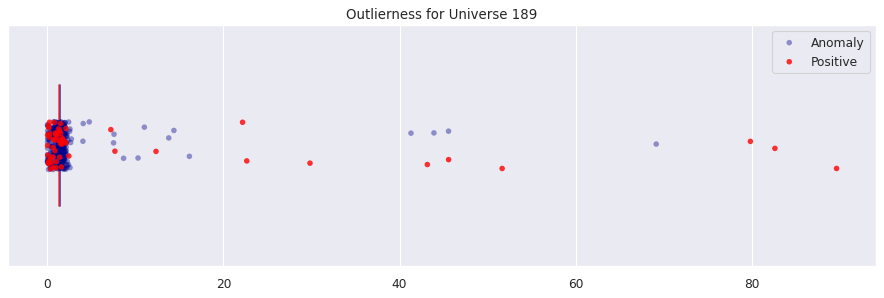

In [163]:
outlierness_supervised(Y_collection, outlierness_dict)

Dropped features: **30** + removed rows

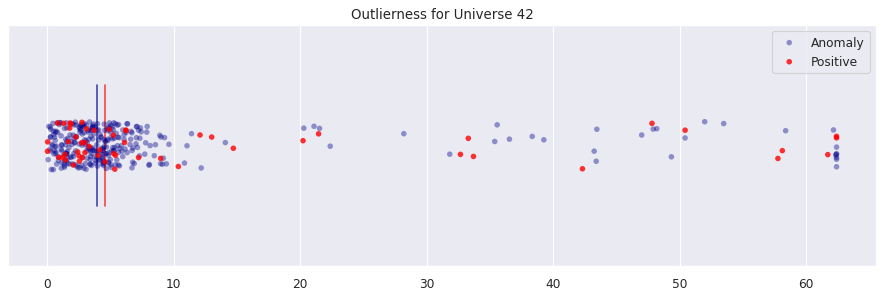

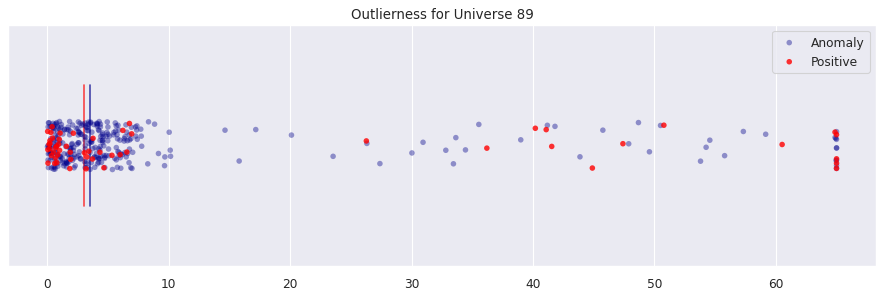

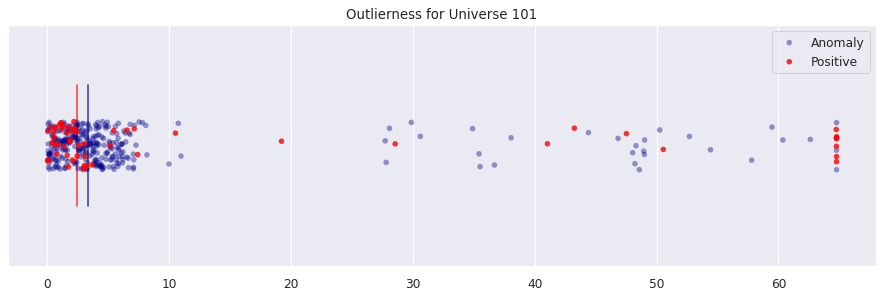

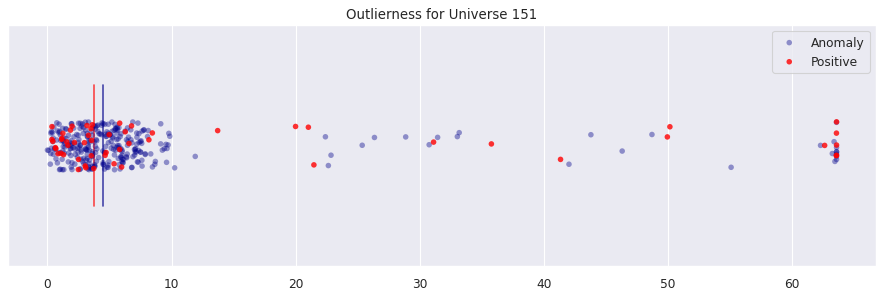

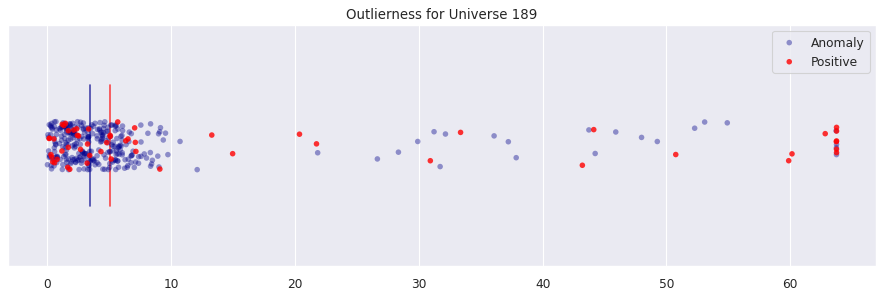

In [170]:
outlierness_supervised(Y_collection, outlierness_dict)

#### Total feature selection analysis

In [23]:
best_difference = 0
best_mean_difference = 0
best_auc = 0

estimator_dict = {}
estimator_ocsvm = OneClassSVM()
        
for feat_drop in tqdm(range(0,35), desc = 'Feature removing'): 
    for filtering in ['var', 'mad', 'var_ratio', 'mad_ratio']:
        
        ########################## Filtering ################################
        
        columns = X_collection[42][0].columns.to_numpy()
        ## Keep columns that are not desired to remove
        keep = ['CD000MSEX', 'CD000FSEX', 'CD0000AGE', 'CTHSDXXSAT']
        columns = np.setdiff1d(columns, keep)
        total_columns = len(X_collection[42][0].columns) - len(keep)

        columns_to_drop = feat_drop

        variance = {k: None for k in columns}
        mad_list = {k: None for k in columns}
        ratio = {k: None for k in columns}
        X_train = {}
        X_test = {}
        for universe in ms:
            positive_index = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index
            for col in columns:
                # Variance
                var = X_collection[universe][0][col].var()
                variance[col] = var
                # Variance with normal samples
                var_pos = X_collection[universe][0].loc[positive_index, :][col].var()
                # Mad
                mad = stats.median_abs_deviation(X_collection[universe][0][col])
                mad_list[col] = mad
                # Mad with normal samples
                mad_pos = stats.median_abs_deviation(X_collection[universe][0].loc[positive_index, :][col])
                
                if (filtering == 'var_ratio'):
                    ratio_value = var/var_pos
                    ratio[col] = ratio_value
                elif (filtering == 'mad_ratio'):
                    ratio_value = mad/mad_pos if mad_pos>0 else mad/0.00001
                    ratio[col] = ratio_value
            if (filtering == 'var_ratio' or filtering == 'mad_ratio'):
                ratio = {k: v for k, v in sorted(ratio.items(), key=lambda item: item[1])}
                ratio_keys = list(ratio.keys())

            variance = {k: v for k, v in sorted(variance.items(), key=lambda item: item[1], reverse=True)}
            variance_keys = list(variance.keys())
            
            mad_list = {k: v for k, v in sorted(mad_list.items(), key=lambda item: item[1], reverse=True)}
            mad_keys = list(mad_list.keys())
            
            if (filtering == 'var'):
                X_train[universe] = X_collection[universe][0].drop(columns=variance_keys[total_columns-columns_to_drop:], axis=1)
                X_test[universe] = X_collection[universe][1].drop(columns=variance_keys[total_columns-columns_to_drop:], axis=1) 
            elif (filtering == 'mad'):
                X_train[universe] = X_collection[universe][0].drop(columns=mad_keys[total_columns-columns_to_drop:], axis=1)
                X_test[universe] = X_collection[universe][1].drop(columns=mad_keys[total_columns-columns_to_drop:], axis=1) 
            else:
                X_train[universe] = X_collection[universe][0].drop(columns=ratio_keys[1*(total_columns-columns_to_drop):], axis=1)
                X_test[universe] = X_collection[universe][1].drop(columns=ratio_keys[1*(total_columns-columns_to_drop):], axis=1) 
    
    
        ########################## Fitting the model ################################
        
        outlierness_dict = {}
        prediction_dict = {}
        total_difference = 0
        for universe in ms:
            # Fit model with train data
            if estimator_dict != {}: estimator_ocsvm = estimator_dict[universe]

            index_normal = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index
            estimator_ocsvm.fit(X_train[universe].loc[index_normal, :])

            # Predict unproccessed outlier-score
            decicision_function = estimator_ocsvm.decision_function(X_test[universe])

            # Process outlier-score or outlierness:
            # Lower the score, lower the likelihood of being outlier.
            # Higher the score, higher the likelihood of being outlier.
            MIN = min(-decicision_function)
            outlier_score = -decicision_function - MIN

            prediction = estimator_ocsvm.predict(X_test[universe])

            outlier_score = pd.Series(outlier_score, index = X_test[universe].index)
            prediction = pd.Series(prediction, index = X_test[universe].index)
        
            positive_index = Y_collection[universe][1].loc[Y_collection[universe][1]['ED0DISWHY']==1].index
            anomaly_index = Y_collection[universe][1].loc[Y_collection[universe][1]['ED0DISWHY']==-1].index
            
            norm_outlier_score = normalize(outlier_score)
            
            positive_median = norm_outlier_score[positive_index].median()
            anomaly_median = norm_outlier_score[anomaly_index].median()
            # OLD
#             difference = abs(positive_median-anomaly_median)
            # NEW
            difference = anomaly_median - positive_median
            
            fpr, tpr, thresholds = roc_curve(Y_collection[universe][1], norm_outlier_score, pos_label=1)
            roc_auc = auc(fpr, tpr)
            
            if (roc_auc > best_auc):
                best_auc = roc_auc
                best_feature_n_auc = feat_drop
                best_filtering_auc = filtering
            
            if (positive_median<anomaly_median and difference>best_difference):
                  best_difference = difference
                  best_feature_n = feat_drop
                  best_filtering = filtering
            
            total_difference += difference
            
        mean_difference = total_difference/len(ms)
        if (mean_difference > best_mean_difference):
              best_mean_difference = mean_difference
              best_feature_n_mean = feat_drop
              best_filtering_mean = filtering
            
print(f'Best configuration (median difference):\n \t * Difference: {best_difference} \n \t * Filtering: {best_filtering} \n \t * Removed features: {best_feature_n}')
print(f'Best configuration (median difference) (mean universe):\n \t * Difference: {best_mean_difference} \n \t * Filtering: {best_filtering_mean} \n \t * Removed features: {best_feature_n_mean}')
print(f'Best configuration (AUC):\n \t * AUC: {best_auc}  \n \t * Filtering: {best_filtering_auc} \n \t * Removed features: {best_feature_n_auc}')


            

Feature removing:   0%|          | 0/35 [00:00<?, ?it/s]

Best configuration (median difference):
 	 * Difference: 0.01934923276103428 
 	 * Filtering: var_ratio 
 	 * Removed features: 33
Best configuration (median difference) (mean universe):
 	 * Difference: 0.008592914341390413 
 	 * Filtering: var_ratio 
 	 * Removed features: 33
Best configuration (AUC):
 	 * AUC: 0.5465275707898659  
 	 * Filtering: var_ratio 
 	 * Removed features: 31


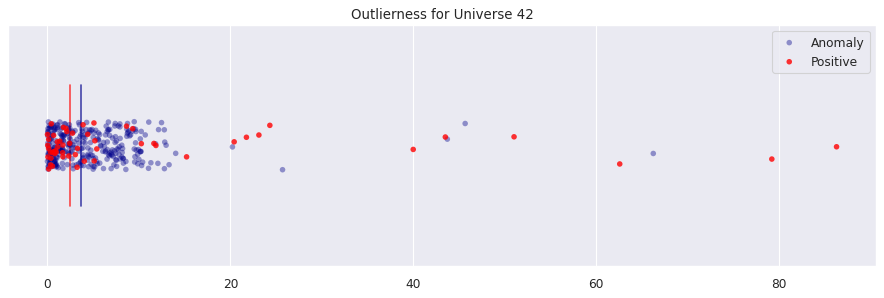

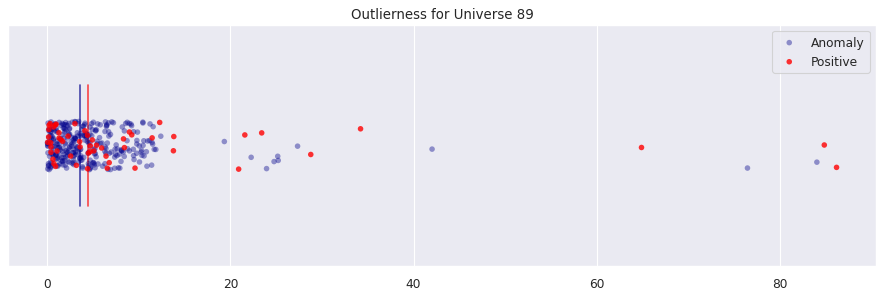

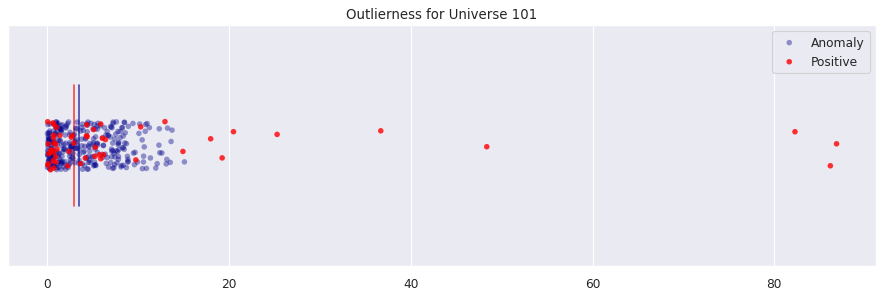

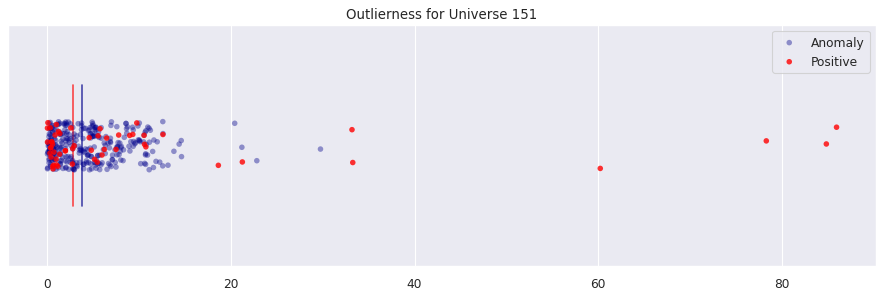

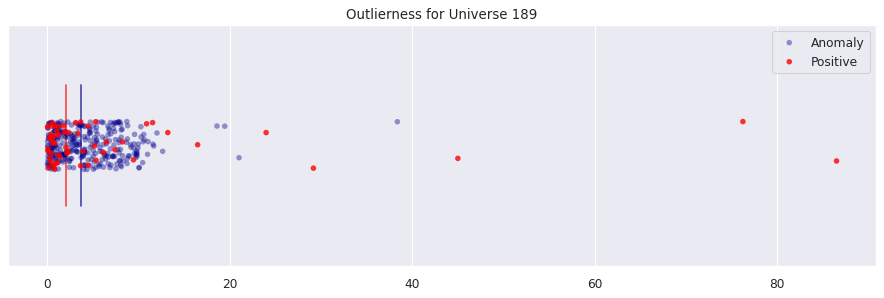

In [31]:
# Configuration:
# * Filtering: var_ratio 
# * Removed features: 33
# * Remaining features: 11

outlierness_supervised(Y_collection, outlierness_dict)

In [59]:
pred = {}

for universe in ms:
    pred[universe] = outlierness_dict[universe].copy()
    pred[universe][outlierness_dict[universe]>4] = -1
    pred[universe][outlierness_dict[universe]<4] = 1
    
    
ev = metric_evaluation(Y_collection, pred, outlierness_dict, 1)

+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Prediction      |   Pos Neg [42]  |   Pos Neg [89]  |  Pos Neg [101]  |  Pos Neg [151]  |  Pos Neg [189]  |
+-----------------+-----------------+-----------------+-----------------+-----------------+-----------------+
| Positive        |       33 22     |       25 30     |       29 26     |       29 26     |       36 19     |
| Negative        |     162 143     |     168 137     |     162 143     |     159 146     |     160 145     |
| --------------- | --------------- | --------------- | --------------- | --------------- | --------------- |
| AUC             |      0.487      |      0.536*     |      0.489      |      0.495      |      0.435      |
| Accuracy        |      0.489      |      0.450      |      0.478      |      0.486      |      0.503*     |
| Precision       |      0.169      |      0.130      |      0.152      |      0.154      |      0.184*     |
| Sensitiv

## Isolation Forest

In [ ]:
iforest = IsolationForest(random_state=42)

normal = 1

iforest_params= {
    'contamination' : [0.7, 0.8, 0.9]
    }

# Obtain model with best hyperparameters: nested-cv
estimator_iforest = nested_cv(X_collection[42][0], Y_collection[42][0], 5,5, model=iforest, parameters=iforest_params, score=f1_score, one_class=1, normal_target = 1)

In [ ]:
estimator_iforest = IsolationForest(contamination=0.8, random_state=42)


In [ ]:
outlierness_dict = {}
prediction_dict = {}

for universe in ms:
    # Fit test data
    index_normal = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index
    estimator_iforest.fit(X_collection[universe][0].loc[index_normal, :])
    
    # Predict unproccessed outlier-score
    decicision_function = estimator_iforest.decision_function(X_collection[universe][1])

    # Process outlier-score or outlierness:
    # Lower the score, lower the likelihood of being outlier.
    # Higher the score, higher the likelihood of being outlier.
    MIN = min(-decicision_function)
    
    ## IsolationForest decision_function is between -0.5 and 0.5, where smaller values mean more anomalous. 
    outlier_score = -decicision_function - MIN
    
    prediction = estimator_iforest.predict(X_collection[universe][1])
    
    outlierness_dict[universe] = pd.Series(outlier_score, index = X_collection[universe][1].index)
    prediction_dict[universe] = pd.Series(prediction, index = X_collection[universe][1].index)


In [ ]:
outlierness_plot_total(Y_collection, prediction_dict, outlierness_dict, 1, -1)

In [ ]:
ev = metric_evaluation(Y_collection, prediction_dict, outlierness_dict, 1)

In [ ]:
ROC_plot_total(Y_collection, outlierness_dict, 1)

In [ ]:
confusion_matrix_plot_total(y_true=Y_collection,y_pred=prediction_dict,labels=[1,-1],normal='deceased',anomaly='not deceased',)

**LOF**

In [ ]:
from sklearn.neighbors import LocalOutlierFactor
LOF = LocalOutlierFactor(novelty=True)

outlierness_dict = {}
prediction_dict = {}

for universe in ms:
    # Fit test data
    index_normal = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index
    LOF.fit(X_collection[universe][0].iloc[index_normal])

    # Predict unproccessed outlier-score
    decicision_function = LOF.decision_function(X_collection[universe][1])

    # Process outlier-score or outlierness:
    # Lower the score, lower the likelihood of being outlier.
    # Higher the score, higher the likelihood of being outlier.
    MIN = min(decicision_function)
    outlier_score = decicision_function - MIN
    
    prediction = pd.Series(LOF.predict(X_collection[42][1]))
    
    outlierness_dict[universe] = pd.Series(outlier_score)
    prediction_dict[universe] = pd.Series(prediction)


In [ ]:
ev = metric_evaluation(Y_collection, prediction_dict, outlierness_dict, 1)

## Autoencoder

In [ ]:
universe = 42
index_normal = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index
X_collection[universe][0].loc[index_normal, :]

In [ ]:
estimator_ae = auto_encoder.AutoEncoder(hidden_neurons=[16, 8, 8, 16], contamination=0.5, epochs=100)
outlierness_dict = {}
# prediction_dict = {}

for universe in ms:
    # Fit test data
    index_normal = Y_collection[universe][0].loc[Y_collection[universe][0]['ED0DISWHY']==1].index
    estimator_ae.fit(X_collection[universe][0].loc[index_normal, :])
    
    # Predict unproccessed ev = metric_evaluation(Y_collection, prediction_dict, outlierness_dict, 1)
    
    decicision_function = estimator_ae.decision_function(X_collection[universe][1])

    # Process outlier-score or outlierness:
    # Lower the score, lower the likelihood of being outlier.
    # Higher the score, higher the likelihood of being outlier.

    outlier_score = decicision_function

    outlierness_dict[universe] = pd.Series(outlier_score, index = X_collection[universe][1].index)
#     prediction_dict[universe] = pd.Series(prediction, index = X_collection[universe][1].index)


In [ ]:
# Visualize outlier-score (UNSUPERVISED WAY)
for universe in ms:
    ax = plt.figure(figsize=(14, 6), dpi=80).gca()
    plt.title(f'Outlierness for Universe {universe}')
    sns.stripplot(x=outlierness_dict[universe], ax = ax)
    plt.xticks(np.arange(min(outlierness_dict[universe]), max(outlierness_dict[universe])+1, 1.0))

In [ ]:
# Visualize outlier-score (SUPERVISED WAY)
for universe in ms:
    ax = plt.figure(figsize=(14, 6), dpi=80).gca()
    plt.title(f'Outlierness for Universe {universe}')
    outlierness_dict[universe]
    
    positive_index = Y_collection[universe][1].loc[Y_collection[universe][1]['ED0DISWHY']==1].index
    anomaly_index = Y_collection[universe][1].loc[Y_collection[universe][1]['ED0DISWHY']==-1].index
    
    sns.stripplot(x=outlierness_dict[universe][positive_index], alpha = .8, edgecolor = 'black', color='red', label='Positive', ax = ax)
    sns.stripplot(x=outlierness_dict[universe][anomaly_index], alpha = .4, edgecolor = 'none', color = 'darkblue', label='Anomaly', ax = ax)
    plt.axvline(x=3.8, color='g', linestyle='-')
    plt.legend()
#     plt.xticks(np.arange(min(outlierness_dict[universe]), max(outlierness_dict[universe])+1, 1.0))

In [ ]:
thresholds = {42: 3.8, 89: 3.8, 101: 3.8, 151:3.8, 189:3.8}

for universe in ms:
    prediction = pd.Series([-1]*X_collection[universe][1].shape[0], index = X_collection[universe][1].index)
    prediction.loc[outlierness_dict[universe]<thresholds[universe]] = 1
    prediction_dict[universe] = prediction

In [ ]:
ev = metric_evaluation(Y_collection, prediction_dict, outlierness_dict, 1)

In [ ]:
ROC_plot_total(Y_collection, outlierness_dict, 1)

In [ ]:
confusion_matrix_plot_total(y_true=Y_collection,y_pred=prediction_dict,labels=[1,-1],normal='deceased',anomaly='not deceased',)

In [ ]:
outlierness_plot_total(Y_collection, prediction_dict, outlierness_dict, 1, -1)

<a id='model:cat_binary'></a>
## Binary (supervised) classification models


In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0,solver='liblinear')
clf.fit(X_collection[42][0], Y_collection[42][0]['ED0DISWHY'])
y_pred = clf.predict(X_collection[42][1])

confusion_matrix_plot(Y_collection[42][1], y_pred, [1,-1], 1, -1, rs=42)

In [ ]:
X_collection[42][0]